In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import optimizers

import keras_cv
from keras_cv import bounding_box
import os
from luketils import visualization

BATCH_SIZE = 16
EPOCHS = 100
CHECKPOINT_PATH = os.getenv("CHECKPOINT_PATH", "checkpoint/")

In [2]:
dataset, dataset_info = keras_cv.datasets.pascal_voc.load(
    split="train", bounding_box_format="xywh", batch_size=9
)

class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

In [3]:
image_size = [640, 640, 3]
train_ds = tfds.load(
    "voc/2007", split="train+test", with_info=False, shuffle_files=True
)
train_ds = train_ds.concatenate(
    tfds.load("voc/2012", split="train+validation", with_info=False, shuffle_files=True)
)
eval_ds = tfds.load("voc/2007", split="test", with_info=False)

In [4]:
train_ds

<ConcatenateDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'image/filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'labels': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'labels_no_difficult': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'objects': {'bbox': TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), 'is_difficult': TensorSpec(shape=(None,), dtype=tf.bool, name=None), 'is_truncated': TensorSpec(shape=(None,), dtype=tf.bool, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'pose': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}}>

In [5]:
eval_ds

<PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'image/filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'labels': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'labels_no_difficult': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'objects': {'bbox': TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), 'is_difficult': TensorSpec(shape=(None,), dtype=tf.bool, name=None), 'is_truncated': TensorSpec(shape=(None,), dtype=tf.bool, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'pose': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}}>

In [6]:
# TODO: migrate to KPL.
def resize_and_crop_image(
    image,
    desired_size,
    padded_size,
    aug_scale_min=1.0,
    aug_scale_max=1.0,
    seed=1,
    method=tf.image.ResizeMethod.BILINEAR,
):
    with tf.name_scope("resize_and_crop_image"):
        image_size = tf.cast(tf.shape(image)[0:2], tf.float32)

        random_jittering = aug_scale_min != 1.0 or aug_scale_max != 1.0

        if random_jittering:
            random_scale = tf.random.uniform(
                [], aug_scale_min, aug_scale_max, seed=seed
            )
            scaled_size = tf.round(random_scale * desired_size)
        else:
            scaled_size = desired_size

        scale = tf.minimum(
            scaled_size[0] / image_size[0], scaled_size[1] / image_size[1]
        )
        scaled_size = tf.round(image_size * scale)

        # Computes 2D image_scale.
        image_scale = scaled_size / image_size

        # Selects non-zero random offset (x, y) if scaled image is larger than
        # desired_size.
        if random_jittering:
            max_offset = scaled_size - desired_size
            max_offset = tf.where(
                tf.less(max_offset, 0), tf.zeros_like(max_offset), max_offset
            )
            offset = max_offset * tf.random.uniform(
                [
                    2,
                ],
                0,
                1,
                seed=seed,
            )
            offset = tf.cast(offset, tf.int32)
        else:
            offset = tf.zeros((2,), tf.int32)

        scaled_image = tf.image.resize(
            image, tf.cast(scaled_size, tf.int32), method=method
        )

        if random_jittering:
            scaled_image = scaled_image[
                offset[0] : offset[0] + desired_size[0],
                offset[1] : offset[1] + desired_size[1],
                :,
            ]

        output_image = tf.image.pad_to_bounding_box(
            scaled_image, 0, 0, padded_size[0], padded_size[1]
        )

        image_info = tf.stack(
            [
                image_size,
                tf.constant(desired_size, dtype=tf.float32),
                image_scale,
                tf.cast(offset, tf.float32),
            ]
        )
        return output_image, image_info


def resize_and_crop_boxes(boxes, image_scale, output_size, offset):
    with tf.name_scope("resize_and_crop_boxes"):
        # Adjusts box coordinates based on image_scale and offset.
        boxes *= tf.tile(tf.expand_dims(image_scale, axis=0), [1, 2])
        boxes -= tf.tile(tf.expand_dims(offset, axis=0), [1, 2])
        # Clips the boxes.
        boxes = clip_boxes(boxes, output_size)
        return boxes


def clip_boxes(boxes, image_shape):
    if boxes.shape[-1] != 4:
        raise ValueError(
            "boxes.shape[-1] is {:d}, but must be 4.".format(boxes.shape[-1])
        )

    with tf.name_scope("clip_boxes"):
        if isinstance(image_shape, list) or isinstance(image_shape, tuple):
            height, width = image_shape
            max_length = [height, width, height, width]
        else:
            image_shape = tf.cast(image_shape, dtype=boxes.dtype)
            height, width = tf.unstack(image_shape, axis=-1)
            max_length = tf.stack([height, width, height, width], axis=-1)

        clipped_boxes = tf.math.maximum(tf.math.minimum(boxes, max_length), 0.0)
        return clipped_boxes


def get_non_empty_box_indices(boxes):
    # Selects indices if box height or width is 0.
    height = boxes[:, 2] - boxes[:, 0]
    width = boxes[:, 3] - boxes[:, 1]
    indices = tf.where(tf.logical_and(tf.greater(height, 0), tf.greater(width, 0)))
    return indices[:, 0]


def resize_fn(image, gt_boxes, gt_classes):
    image, image_info = resize_and_crop_image(
        image, image_size[:2], image_size[:2], 0.8, 1.25
    )
    gt_boxes = resize_and_crop_boxes(
        gt_boxes, image_info[2, :], image_info[1, :], image_info[3, :]
    )
    indices = get_non_empty_box_indices(gt_boxes)
    gt_boxes = tf.gather(gt_boxes, indices)
    gt_classes = tf.gather(gt_classes, indices)
    return image, gt_boxes, gt_classes


def flip_fn(image, boxes):
    if tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32) > 0.5:
        image = tf.image.flip_left_right(image)
        y1, x1, y2, x2 = tf.split(boxes, num_or_size_splits=4, axis=-1)
        boxes = tf.concat([y1, 1.0 - x2, y2, 1.0 - x1], axis=-1)
    return image, boxes


In [7]:
def proc_train_fn(bounding_box_format, img_size):
    def apply(inputs):
        image = inputs["image"]
        image = tf.cast(image, tf.float32)
        gt_boxes = inputs["objects"]["bbox"]
        image, gt_boxes = flip_fn(image, gt_boxes)
        gt_boxes = keras_cv.bounding_box.convert_format(
            gt_boxes,
            images=image,
            source="rel_yxyx",
            target='yxyx',
        )
        gt_classes = tf.cast(inputs["objects"]["label"], tf.float32)
        image, gt_boxes, gt_classes = resize_fn(image, gt_boxes, gt_classes)
        gt_classes = tf.expand_dims(gt_classes, axis=-1)
        bounding_boxes = tf.concat([gt_boxes, gt_classes], axis=-1)
        bounding_boxes = keras_cv.bounding_box.convert_format(
            bounding_boxes,
            images=image,
            source='yxyx',
            target=bounding_box_format
        )
        return {
            "images": image,
            "bounding_boxes": bounding_boxes
        }
    return apply

In [8]:
train_ds = train_ds.map(proc_train_fn('xywh', image_size), num_parallel_calls=tf.data.AUTOTUNE)

In [9]:
train_ds = train_ds.apply(
    tf.data.experimental.dense_to_ragged_batch(8, drop_remainder=True)
)

In [10]:
eval_ds = eval_ds.map(
    proc_train_fn(bounding_box_format="xywh", img_size=image_size),
    num_parallel_calls=tf.data.AUTOTUNE,
)

In [11]:
eval_ds = eval_ds.apply(
    tf.data.experimental.dense_to_ragged_batch(8, drop_remainder=True)
)

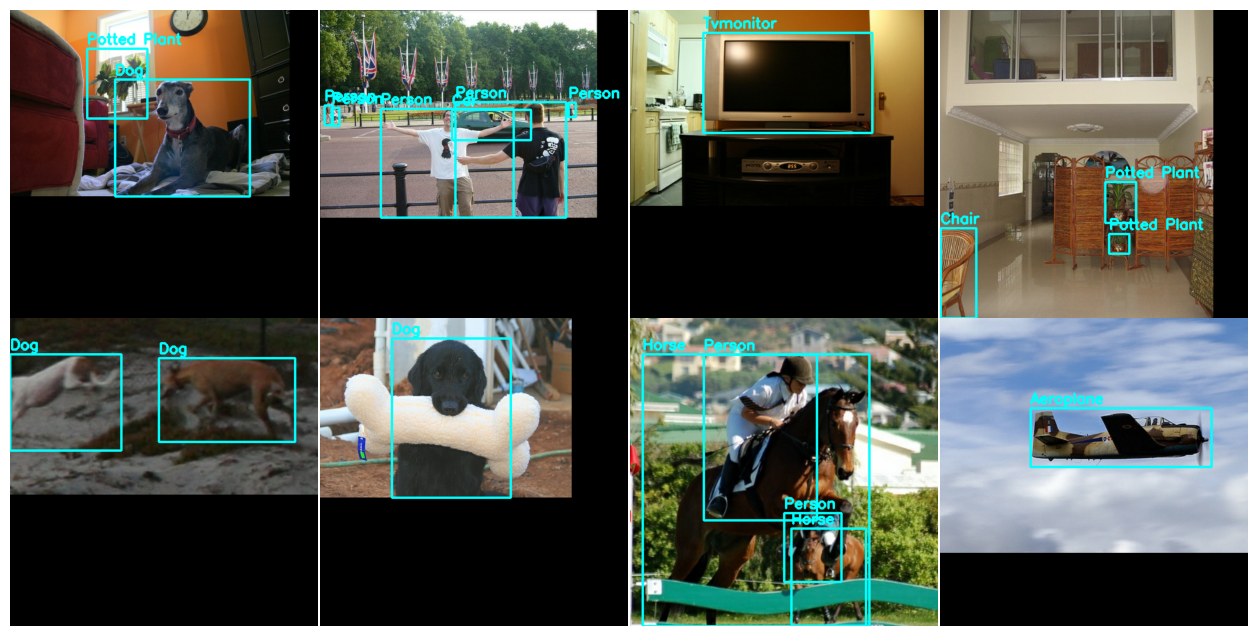

In [12]:
def visualize_dataset(dataset, bounding_box_format):
    example = next(iter(dataset))
    images, boxes = example["images"], example["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=boxes,
        scale=4,
        rows=2,
        cols=4,
        thickness=4,
        font_scale=1,
        class_mapping=class_mapping,
        show=True,
    )

visualize_dataset(train_ds, bounding_box_format="xywh")

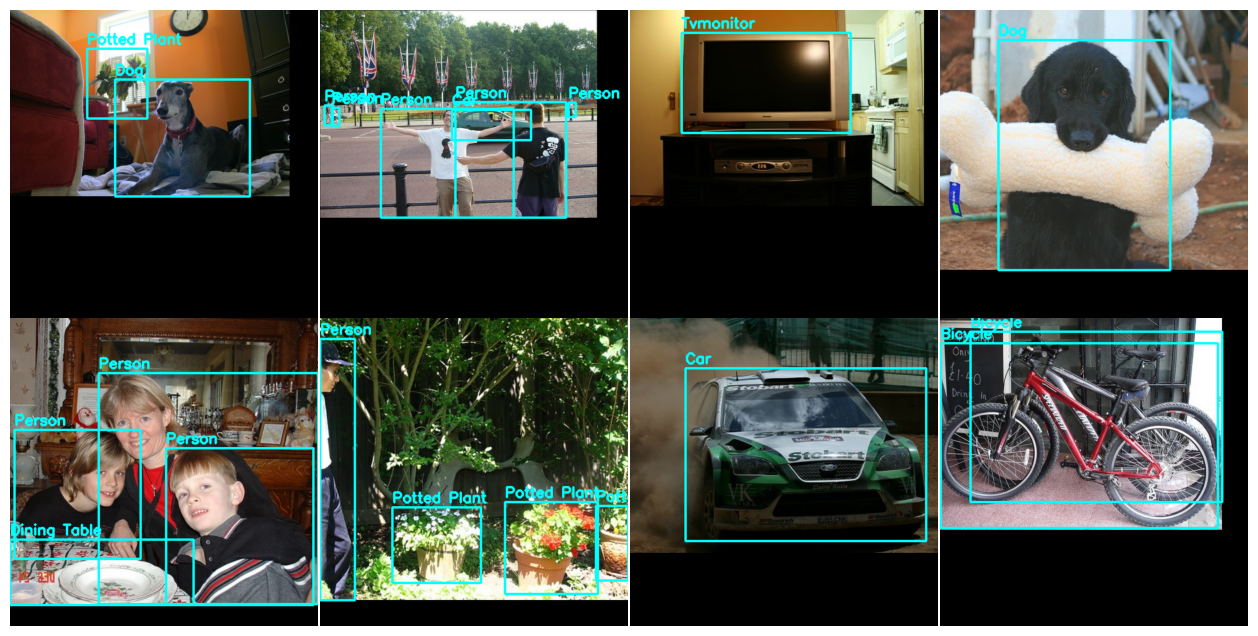

In [13]:
visualize_dataset(eval_ds, bounding_box_format="xywh")

In [14]:
train_ds = train_ds.prefetch(2)
train_ds = train_ds.shuffle(8)
eval_ds = eval_ds.prefetch(2)

In [15]:
def unpackage_dict(inputs):
    return inputs['images'], inputs['bounding_boxes']

In [16]:
train_ds = train_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = eval_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)

In [17]:
model = keras_cv.models.RetinaNet(
    # number of classes to be used in box classification
    classes=20,
    # For more info on supported bounding box formats, visit
    # https://keras.io/api/keras_cv/bounding_box/
    bounding_box_format="xywh",
    # KerasCV offers a set of pre-configured backbones
    backbone="resnet50",
    # Each backbone comes with multiple pre-trained weights
    # These weights match the weights available in the `keras_cv.model` class.
    backbone_weights="imagenet",
    # include_rescaling tells the model whether your input images are in the default
    # pixel range (0, 255) or if you have already rescaled your inputs to the range
    # (0, 1).  In our case, we feed our model images with inputs in the range (0, 255).
    include_rescaling=True,
    # Typically, you'll want to set this to False when training a real model.
    # evaluate_train_time_metrics=True makes `train_step()` incompatible with TPU,
    # and also causes a massive performance hit.  It can, however be useful to produce
    # train time metrics when debugging your model training pipeline.
    evaluate_train_time_metrics=False,
)
# Fine-tuning a RetinaNet is as simple as setting backbone.trainable = False
model.backbone.trainable = False

In [18]:
metrics = [
    keras_cv.metrics.COCOMeanAveragePrecision(
        class_ids=range(21),
        bounding_box_format="xywh",
        name="Mean Average Precision",
    ),
    keras_cv.metrics.COCORecall(
        class_ids=range(21),
        bounding_box_format="xywh",
        max_detections=100,
        name="Recall",
    ),
]

## Training our model

All that is left to do is train our model.  KerasCV object detection models follow the
standard Keras workflow, leveraging `compile()` and `fit()`.

Let's compile our model:

In [19]:
optimizer = tf.optimizers.SGD(global_clipnorm=10.0)
model.compile(
    classification_loss=keras_cv.losses.FocalLoss(from_logits=True, reduction="none"),
    box_loss=keras_cv.losses.SmoothL1Loss(l1_cutoff=1.0, reduction="none"),
    optimizer=optimizer,
    metrics=metrics,
)

Next, we can construct some callbacks:

In [20]:
callbacks = [
    keras.callbacks.TensorBoard(log_dir="logs"),
    keras.callbacks.ReduceLROnPlateau(patience=5),
    keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, save_weights_only=True),
]

And run `model.fit()`!

In [21]:
history = model.fit(
    train_ds,
    validation_data=eval_ds.take(10),
    epochs=100,
    callbacks=callbacks,
)

Epoch 1/100
2374/2374 [==============================] - 203s 80ms/step - loss: 8.1273 - classification_loss: 3.9964 - regularization_loss: 0.0000e+00 - box_loss: 4.1309 - val_Mean Average Precision: 0.1359 - val_Recall: 0.1610 - val_loss: 6.5227 - val_classification_loss: 3.0697 - val_box_loss: 3.4530 - val_regularization_loss: 0.0000e+00 - lr: 0.0100
Epoch 2/100
2374/2374 [==============================] - 186s 78ms/step - loss: 5.7149 - classification_loss: 2.6686 - regularization_loss: 0.0000e+00 - box_loss: 3.0464 - val_Mean Average Precision: 0.2017 - val_Recall: 0.2594 - val_loss: 5.3149 - val_classification_loss: 2.2308 - val_box_loss: 3.0841 - val_regularization_loss: 0.0000e+00 - lr: 0.0100
Epoch 3/100
2374/2374 [==============================] - 185s 78ms/step - loss: 4.9979 - classification_loss: 2.2925 - regularization_loss: 0.0000e+00 - box_loss: 2.7054 - val_Mean Average Precision: 0.2554 - val_Recall: 0.3468 - val_loss: 4.7856 - val_classification_loss: 2.1151 - val_box

KeyboardInterrupt: 

# Vizualization

1/1 [==============================] - 2s 2s/step


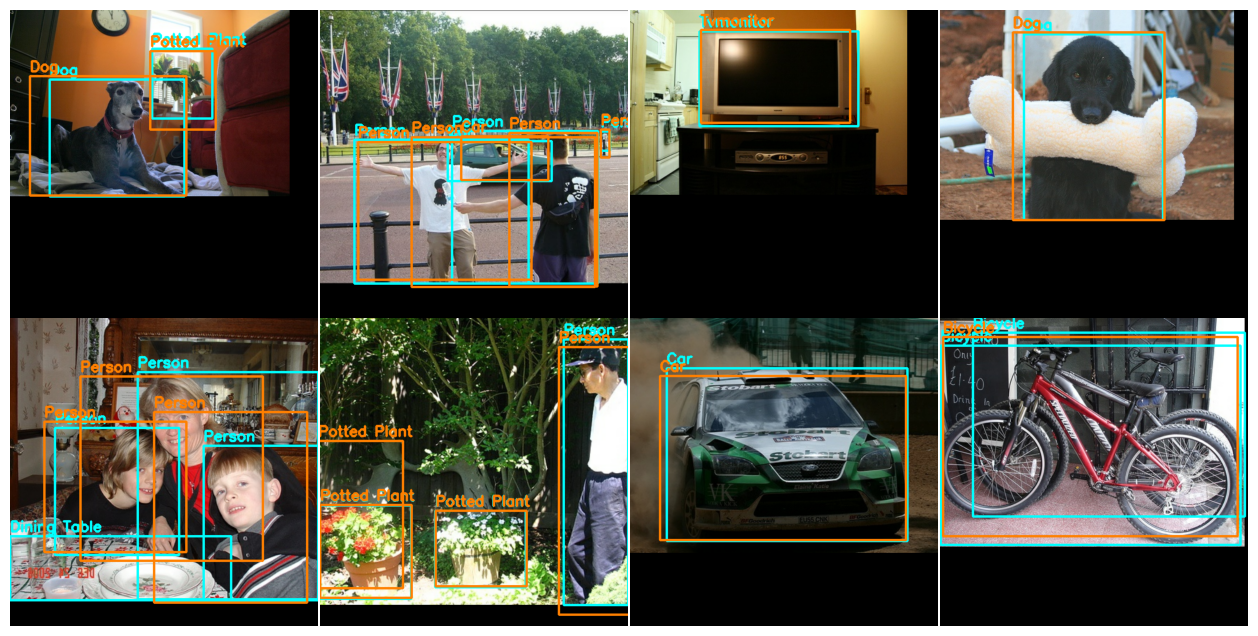

In [22]:
images, y_true = next(iter(eval_ds.take(1)))
y_pred = model.predict(images)
visualization.plot_bounding_box_gallery(
    images,
    value_range=(0, 255),
    bounding_box_format='xywh',
    y_true=y_true,
    y_pred=y_pred,
    scale=4,
    rows=2,
    cols=4,
    show=True,
    thickness=4,
    font_scale=1,
    class_mapping=class_mapping,
)

In [23]:
import luketils

In [ ]:
metrics = history.history

In [ ]:
metrics_to_plot = {
    'Train': metrics['loss'],
    'Validation': metrics['val_loss'],
    'Train Box Loss': metrics['box_loss'],
    'Validation Box Loss': metrics['val_box_loss'],
    'Train Classification Loss': metrics['classification_loss'],
    'Validation Classification Loss': metrics['val_classification_loss'],
}

luketils.visualization.line_plot(
    data=metrics_to_plot, 
    title='Loss', 
    xlabel='Epochs', 
    ylabel='Loss', 
    transparent=True
)

In [ ]:
metrics_to_plot = {
    'Mean Average Precision': metrics['val_MaP'],
    'Recall': metrics['val_Recall'],
}

luketils.visualization.line_plot(
    data=metrics_to_plot, 
    title='Loss', 
    xlabel='Epochs', 
    ylabel='Loss', 
    transparent=True
)

# Model Evaluation

Lets perform model evaluation.

First, lets plot out the learning curves of our losses and metrics:

Next, we can evaluate the metrics by re-compiling the model, and running
`model.evaluate()`:

In [24]:
import keras_cv
coco_suite = [
    keras_cv.metrics.COCOMeanAveragePrecision(
        bounding_box_format="xywh",
        class_ids=range(20),
        max_detections=100,
        name='MaP Standard'
    ),
    keras_cv.metrics.COCOMeanAveragePrecision(
        bounding_box_format="xywh",
        class_ids=range(20),
        iou_thresholds=[0.75],
        max_detections=100,
        name='MaP@IoU=0.75'
    ),
    keras_cv.metrics.COCOMeanAveragePrecision(
        bounding_box_format="xywh",
        class_ids=range(20),
        iou_thresholds=[0.5],
        max_detections=100,
        name='MaP@IoU=0.5'
    ),
    keras_cv.metrics.COCOMeanAveragePrecision(
        bounding_box_format="xywh",
        class_ids=range(20),
        area_range=(0, 32**2),
        max_detections=100,
        name="MaP Small"
    ),
    keras_cv.metrics.COCOMeanAveragePrecision(
        bounding_box_format="xywh",
        class_ids=range(20),
        area_range=(32**2, 96**2),
        max_detections=100,
        name="MaP Medium"
    ),
    keras_cv.metrics.COCOMeanAveragePrecision(
        bounding_box_format="xywh",
        class_ids=range(20),
        area_range=(96**2, 1e5**2),
        max_detections=100,
        name="MaP Large"
    ),
    keras_cv.metrics.COCORecall(
        class_ids=range(20),
        bounding_box_format="xywh",
        max_detections=100,
        name="Recall Standard",
    ),
    keras_cv.metrics.COCORecall(
        class_ids=range(20),
        bounding_box_format="xywh",
        max_detections=1,
        name="Recall MaxDets=1",
    ),
    keras_cv.metrics.COCORecall(
        class_ids=range(20),
        bounding_box_format="xywh",
        max_detections=10,
        name="Recall MaxDets=10",
    ),
    keras_cv.metrics.COCORecall(
        class_ids=range(20),
        bounding_box_format="xywh",
        max_detections=100,
        area_range=(0, 32**2),
        name="Recall Small",
    ),
    keras_cv.metrics.COCORecall(
        class_ids=range(20),
        bounding_box_format="xywh",
        max_detections=100,
        area_range=(32**2, 96**2),
        name="Recall Medium",
    ),
    keras_cv.metrics.COCORecall(
        class_ids=range(20),
        bounding_box_format="xywh",
        max_detections=100,
        area_range=(96**2, 1e5**2),
        name="Recall Large",
    ),
]

In [25]:
model.compile(
    classification_loss=keras_cv.losses.FocalLoss(from_logits=True, reduction="none"),
    box_loss=keras_cv.losses.SmoothL1Loss(l1_cutoff=1.0, reduction="none"),
    optimizer=optimizer,
    metrics=coco_suite,
)

In [26]:
from pycocotools import coco
from pycocotools import cocoeval

In [27]:
model.load_weights(CHECKPOINT_PATH)

In [ ]:
keras_cv_metrics = model.evaluate(eval_ds, return_dict=True)
print(keras_cv_metrics)

113/619 [====>.........................] - ETA: 1:12:02 - MaP Standard: 0.2598 - MaP@IoU=0.75: 0.2680 - MaP@IoU=0.5: 0.4522 - MaP Small: 0.0415 - MaP Medium: 0.2061 - MaP Large: 0.3111 - Recall Standard: 0.5278 - Recall MaxDets=1: 0.3946 - Recall MaxDets=10: 0.5234 - Recall Small: 0.0582 - Recall Medium: 0.4023 - Recall Large: 0.6132 - loss: 2.4927 - classification_loss: 1.0913 - box_loss: 1.4014 - regularization_loss: 0.0000e+00

In [34]:
keras_cv_metrics

{'MaP Standard': 0.2555176615715027,
 'MaP@IoU=0.75': 0.263761967420578,
 'MaP@IoU=0.5': 0.44937071204185486,
 'MaP Small': 0.040791306644678116,
 'MaP Medium': 0.1274954080581665,
 'MaP Large': 0.3064923584461212,
 'Recall Standard': 0.531278133392334,
 'Recall MaxDets=1': 0.4007943272590637,
 'Recall MaxDets=10': 0.5271714925765991,
 'Recall Small': 0.06190967559814453,
 'Recall Medium': 0.32170534133911133,
 'Recall Large': 0.6164597272872925,
 'loss': 2.46925950050354,
 'classification_loss': 1.0753881931304932,
 'box_loss': 1.3938723802566528,
 'regularization_loss': 0.0}

In [201]:
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import six
import tensorflow_datasets as tfds

from pycocotools import coco
from pycocotools import cocoeval
from PIL import Image
import copy
import keras_cv
import keras_cv.layers
from keras_cv import bounding_box
from keras.utils import data_utils


import numpy as np
import six
class COCOWrapper(coco.COCO):
  """COCO wrapper class.
  This class wraps COCO API object, which provides the following additional
  functionalities:
    1. Support string type image id.
    2. Support loading the groundtruth dataset using the external annotation
       dictionary.
    3. Support loading the prediction results using the external annotation
       dictionary.
  """

  def __init__(self, gt_dataset=None):
    """Instantiates a COCO-style API object.
    Args:
      eval_type: either 'box' or 'mask'.
      annotation_file: a JSON file that stores annotations of the eval dataset.
        This is required if `gt_dataset` is not provided.
      gt_dataset: the groundtruth eval datatset in COCO API format.
    """

    coco.COCO.__init__(self, annotation_file=None)
    self._eval_type = 'box'
    if gt_dataset:
      self.dataset = gt_dataset
      self.createIndex()

  def loadRes(self, predictions):
    """Loads result file and return a result api object.
    Args:
      predictions: a list of dictionary each representing an annotation in COCO
        format. The required fields are `image_id`, `category_id`, `score`,
        `bbox`, `segmentation`.
    Returns:
      res: result COCO api object.
    Raises:
      ValueError: if the set of image id from predctions is not the subset of
        the set of image id of the groundtruth dataset.
    """
    res = coco.COCO()
    res.dataset['images'] = copy.deepcopy(self.dataset['images'])
    res.dataset['categories'] = copy.deepcopy(self.dataset['categories'])

    image_ids = [ann['image_id'] for ann in predictions]
    if set(image_ids) != (set(image_ids) & set(self.getImgIds())):
      raise ValueError('Results do not correspond to the current dataset!')
    for ann in predictions:
      x1, x2, y1, y2 = [ann['bbox'][0], ann['bbox'][0] + ann['bbox'][2],
                        ann['bbox'][1], ann['bbox'][1] + ann['bbox'][3]]

      ann['area'] = ann['bbox'][2] * ann['bbox'][3]
      ann['segmentation'] = [
          [x1, y1, x1, y2, x2, y2, x2, y1]]

    res.dataset['annotations'] = copy.deepcopy(predictions)
    res.createIndex()
    return res

def yxyx_to_xywh(boxes):
  if boxes.shape[-1] != 4:
    raise ValueError(
        'boxes.shape[-1] is {:d}, but must be 4.'.format(boxes.shape[-1]))

  boxes_ymin = boxes[..., 0]
  boxes_xmin = boxes[..., 1]
  boxes_width = boxes[..., 3] - boxes[..., 1]
  boxes_height = boxes[..., 2] - boxes[..., 0]
  new_boxes = np.stack(
      [boxes_xmin, boxes_ymin, boxes_width, boxes_height], axis=-1)

  return new_boxes

def convert_predictions_to_coco_annotations(predictions):
  coco_predictions = []
  num_batches = len(predictions['source_id'])
  use_outer_box = 'detection_outer_boxes' in predictions
  for i in range(num_batches):
    predictions['detection_boxes'][i] = yxyx_to_xywh(
        predictions['detection_boxes'][i])
    if use_outer_box:
      predictions['detection_outer_boxes'][i] = yxyx_to_xywh(
          predictions['detection_outer_boxes'][i])
      mask_boxes = predictions['detection_outer_boxes']
    else:
      mask_boxes = predictions['detection_boxes']

    batch_size = predictions['source_id'][i].shape[0]
    for j in range(batch_size):
      max_num_detections = predictions['num_detections'][i][j]
      for k in range(max_num_detections):
        ann = {}
        ann['image_id'] = predictions['source_id'][i][j]
        ann['category_id'] = predictions['detection_classes'][i][j, k]
        ann['bbox'] = predictions['detection_boxes'][i][j, k]
        ann['score'] = predictions['detection_scores'][i][j, k]
        coco_predictions.append(ann)

  for i, ann in enumerate(coco_predictions):
    ann['id'] = i + 1

  return coco_predictions

def convert_groundtruths_to_coco_dataset(groundtruths, label_map=None):
  source_ids = np.concatenate(groundtruths['source_id'], axis=0)
  heights = np.concatenate(groundtruths['height'], axis=0)
  widths = np.concatenate(groundtruths['width'], axis=0)
  gt_images = [{'id': int(i), 'height': int(h), 'width': int(w)} for i, h, w
               in zip(source_ids, heights, widths)]

  gt_annotations = []
  num_batches = len(groundtruths['source_id'])
  for i in range(num_batches):
    max_num_instances = groundtruths['classes'][i].shape[1]
    batch_size = groundtruths['source_id'][i].shape[0]
    for j in range(batch_size):
      num_instances = groundtruths['num_detections'][i][j]
      if num_instances > max_num_instances:
        num_instances = max_num_instances
      for k in range(int(num_instances)):
        ann = {}
        ann['image_id'] = int(groundtruths['source_id'][i][j])
        if 'is_crowds' in groundtruths:
          ann['iscrowd'] = int(groundtruths['is_crowds'][i][j, k])
        else:
          ann['iscrowd'] = 0
        ann['category_id'] = int(groundtruths['classes'][i][j, k])
        boxes = groundtruths['boxes'][i]
        ann['bbox'] = [
            float(boxes[j, k, 1]),
            float(boxes[j, k, 0]),
            float(boxes[j, k, 3] - boxes[j, k, 1]),
            float(boxes[j, k, 2] - boxes[j, k, 0])]
        if 'areas' in groundtruths:
          ann['area'] = float(groundtruths['areas'][i][j, k])
        else:
          ann['area'] = float(
              (boxes[j, k, 3] - boxes[j, k, 1]) *
              (boxes[j, k, 2] - boxes[j, k, 0]))
        gt_annotations.append(ann)

  for i, ann in enumerate(gt_annotations):
    ann['id'] = i + 1

  if label_map:
    gt_categories = [{'id': i, 'name': label_map[i]} for i in label_map]
  else:
    category_ids = [gt['category_id'] for gt in gt_annotations]
    gt_categories = [{'id': i} for i in set(category_ids)]

  gt_dataset = {
      'images': gt_images,
      'categories': gt_categories,
      'annotations': copy.deepcopy(gt_annotations),
  }
  return gt_dataset

class COCOEvaluator(object):
  """COCO evaluation metric class."""

  def __init__(self,
               per_category_metrics=False):
    self._per_category_metrics = per_category_metrics
    self._metric_names = [
        'AP', 'AP50', 'AP75', 'APs', 'APm', 'APl', 'ARmax1', 'ARmax10',
        'ARmax100', 'ARs', 'ARm', 'ARl'
    ]
    self._required_prediction_fields = [
        'source_id', 'num_detections', 'detection_classes', 'detection_scores',
        'detection_boxes'
    ]
    self._required_groundtruth_fields = [
        'source_id', 'height', 'width', 'classes', 'boxes'
    ]

    self.reset_states()

  def reset_states(self):
    """Resets internal states for a fresh run."""
    self._predictions = {}
    self._groundtruths = {}

  def result(self):
    """Evaluates detection results, and reset_states."""
    metric_dict = self.evaluate()
    # Cleans up the internal variables in order for a fresh eval next time.
    self.reset_states()
    return metric_dict

  def evaluate(self):
    """Evaluates with detections from all images with COCO API.
    Returns:
      coco_metric: float numpy array with shape [24] representing the
        coco-style evaluation metrics (box and mask).
    """
    gt_dataset = convert_groundtruths_to_coco_dataset(
        self._groundtruths)
    coco_gt = COCOWrapper(
        gt_dataset=gt_dataset)
    coco_predictions = convert_predictions_to_coco_annotations(
        self._predictions)
    coco_dt = coco_gt.loadRes(predictions=coco_predictions)
    image_ids = [ann['image_id'] for ann in coco_predictions]

    coco_eval = cocoeval.COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.params.imgIds = image_ids
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    coco_metrics = coco_eval.stats

    metrics = coco_metrics

    metrics_dict = {}
    for i, name in enumerate(self._metric_names):
      metrics_dict[name] = metrics[i].astype(np.float32)

    # Adds metrics per category.
    if self._per_category_metrics:
      metrics_dict.update(self._retrieve_per_category_metrics(coco_eval))

    return metrics_dict

  def _retrieve_per_category_metrics(self, coco_eval, prefix=''):
    """Retrieves and per-category metrics and retuns them in a dict.
    Args:
      coco_eval: a cocoeval.COCOeval object containing evaluation data.
      prefix: str, A string used to prefix metric names.
    Returns:
      metrics_dict: A dictionary with per category metrics.
    """

    metrics_dict = {}
    if prefix:
      prefix = prefix + ' '

    if hasattr(coco_eval, 'category_stats'):
      for category_index, category_id in enumerate(coco_eval.params.catIds):
        category_display_name = category_id

        metrics_dict[prefix + 'Precision mAP ByCategory/{}'.format(
            category_display_name
        )] = coco_eval.category_stats[0][category_index].astype(np.float32)
        metrics_dict[prefix + 'Precision mAP ByCategory@50IoU/{}'.format(
            category_display_name
        )] = coco_eval.category_stats[1][category_index].astype(np.float32)
        metrics_dict[prefix + 'Precision mAP ByCategory@75IoU/{}'.format(
            category_display_name
        )] = coco_eval.category_stats[2][category_index].astype(np.float32)
        metrics_dict[prefix + 'Precision mAP ByCategory (small) /{}'.format(
            category_display_name
        )] = coco_eval.category_stats[3][category_index].astype(np.float32)
        metrics_dict[prefix + 'Precision mAP ByCategory (medium) /{}'.format(
            category_display_name
        )] = coco_eval.category_stats[4][category_index].astype(np.float32)
        metrics_dict[prefix + 'Precision mAP ByCategory (large) /{}'.format(
            category_display_name
        )] = coco_eval.category_stats[5][category_index].astype(np.float32)
        metrics_dict[prefix + 'Recall AR@1 ByCategory/{}'.format(
            category_display_name
        )] = coco_eval.category_stats[6][category_index].astype(np.float32)
        metrics_dict[prefix + 'Recall AR@10 ByCategory/{}'.format(
            category_display_name
        )] = coco_eval.category_stats[7][category_index].astype(np.float32)
        metrics_dict[prefix + 'Recall AR@100 ByCategory/{}'.format(
            category_display_name
        )] = coco_eval.category_stats[8][category_index].astype(np.float32)
        metrics_dict[prefix + 'Recall AR (small) ByCategory/{}'.format(
            category_display_name
        )] = coco_eval.category_stats[9][category_index].astype(np.float32)
        metrics_dict[prefix + 'Recall AR (medium) ByCategory/{}'.format(
            category_display_name
        )] = coco_eval.category_stats[10][category_index].astype(np.float32)
        metrics_dict[prefix + 'Recall AR (large) ByCategory/{}'.format(
            category_display_name
        )] = coco_eval.category_stats[11][category_index].astype(np.float32)

    return metrics_dict

  def _convert_to_numpy(self, groundtruths, predictions):
    """Converts tesnors to numpy arrays."""
    if groundtruths:
      labels = tf.nest.map_structure(lambda x: x.numpy(), groundtruths)
      numpy_groundtruths = {}
      for key, val in labels.items():
        if isinstance(val, tuple):
          val = np.concatenate(val)
        numpy_groundtruths[key] = val
    else:
      numpy_groundtruths = groundtruths

    if predictions:
      outputs = tf.nest.map_structure(lambda x: x.numpy(), predictions)
      numpy_predictions = {}
      for key, val in outputs.items():
        if isinstance(val, tuple):
          val = np.concatenate(val)
        numpy_predictions[key] = val
    else:
      numpy_predictions = predictions

    return numpy_groundtruths, numpy_predictions

  def update_state(self, groundtruths, predictions):
    """Update and aggregate detection results and groundtruth data.
    Args:
      groundtruths: a dictionary of Tensors including the fields below.
        See also different parsers under `../dataloader` for more details.
        Required fields:
          - source_id: a numpy array of int or string of shape [batch_size].
          - height: a numpy array of int of shape [batch_size].
          - width: a numpy array of int of shape [batch_size].
          - num_detections: a numpy array of int of shape [batch_size].
          - boxes: a numpy array of float of shape [batch_size, K, 4].
          - classes: a numpy array of int of shape [batch_size, K].
        Optional fields:
          - is_crowds: a numpy array of int of shape [batch_size, K]. If the
              field is absent, it is assumed that this instance is not crowd.
          - areas: a numy array of float of shape [batch_size, K]. If the
              field is absent, the area is calculated using either boxes or
              masks depending on which one is available.
          - masks: a numpy array of float of shape
              [batch_size, K, mask_height, mask_width],
      predictions: a dictionary of tensors including the fields below.
        See different parsers under `../dataloader` for more details.
        Required fields:
          - source_id: a numpy array of int or string of shape [batch_size].
          - image_info [if `need_rescale_bboxes` is True]: a numpy array of
            float of shape [batch_size, 4, 2].
          - num_detections: a numpy array of
            int of shape [batch_size].
          - detection_boxes: a numpy array of float of shape [batch_size, K, 4].
          - detection_classes: a numpy array of int of shape [batch_size, K].
          - detection_scores: a numpy array of float of shape [batch_size, K].
        Optional fields:
          - detection_masks: a numpy array of float of shape
              [batch_size, K, mask_height, mask_width].
    Raises:
      ValueError: if the required prediction or groundtruth fields are not
        present in the incoming `predictions` or `groundtruths`.
    """
    groundtruths, predictions = self._convert_to_numpy(groundtruths,
                                                       predictions)
    for k in self._required_prediction_fields:
      if k not in predictions:
        raise ValueError(
            'Missing the required key `{}` in predictions!'.format(k))
    for k, v in six.iteritems(predictions):
      if k not in self._predictions:
        self._predictions[k] = [v]
      else:
        self._predictions[k].append(v)

    assert groundtruths
    for k in self._required_groundtruth_fields:
      if k not in groundtruths:
        raise ValueError(
            'Missing the required key `{}` in groundtruths!'.format(k))
    for k, v in six.iteritems(groundtruths):
      if k not in self._groundtruths:
        self._groundtruths[k] = [v]
      else:
        self._groundtruths[k].append(v)

In [252]:
def proc_eval_fn(bounding_box_format, target_size):
    def apply(inputs):
        source_id = tf.strings.to_number(
            tf.strings.split(inputs["image/filename"], '.')[0], tf.int64)
        raw_image = inputs["image"]
        raw_image = tf.cast(raw_image, tf.float32)
        
        img_size = tf.shape(raw_image)
        height = img_size[0]
        width = img_size[1]
        
        target_height = tf.cond(
            height > width, 
            lambda: 640.0,
            lambda: tf.cast(height/width * 640.0, tf.float32)
        )
        target_width = tf.cond(
            width > height, 
            lambda: 640.0,
            lambda: tf.cast(width/height * 640.0, tf.float32)
        )
        image = tf.image.resize(
            raw_image,
            (target_height, target_width),
            antialias=False
        )
        
        gt_boxes = keras_cv.bounding_box.convert_format(
            inputs["objects"]["bbox"],
            images=image,
            source="rel_yxyx",
            target='xyxy',
        )
        image = tf.image.pad_to_bounding_box(
            image, 0, 0, target_size[0], target_size[1]
        )
        gt_boxes = keras_cv.bounding_box.convert_format(
            gt_boxes,
            images=image,
            source="xyxy",
            target=bounding_box_format,
        )
        gt_classes = tf.cast(inputs["objects"]["label"], tf.float32)
        gt_classes = tf.expand_dims(gt_classes, axis=-1)
        return {
            "source_id": source_id,
            "raw_images": raw_image,
            "images": image,
            "gt_boxes": gt_boxes,
            "gt_classes": gt_classes,
        }

    return apply

In [253]:
def pad_fn(examples):
    gt_boxes = examples.pop("gt_boxes")
    gt_classes = examples.pop("gt_classes")
    examples["gt_boxes"] = gt_boxes.to_tensor(default_value=-1.0)
    examples["gt_classes"] = gt_classes.to_tensor(default_value=-1.0)
    return examples

In [254]:
eval_ds = tfds.load("voc/2007", split="test", with_info=False, shuffle_files=True)
eval_ds = eval_ds.map(
    proc_eval_fn("xywh", [640, 640, 3]), num_parallel_calls=tf.data.AUTOTUNE
)
eval_ds = eval_ds.apply(
    tf.data.experimental.dense_to_ragged_batch(1, drop_remainder=True)
)
eval_ds = eval_ds.map(pad_fn, num_parallel_calls=tf.data.AUTOTUNE)

In [255]:
evaluator = COCOEvaluator()

def eval_pycoco_step(examples):
    images = examples["images"]
    gt_boxes = examples["gt_boxes"]
    gt_boxes = keras_cv.bounding_box.convert_format(gt_boxes, source='xywh', target='yxyx')
    
    gt_classes = examples["gt_classes"]
    ground_truth = {}
    ground_truth["source_id"] = examples["source_id"]
    ground_truth["height"] = tf.tile(tf.constant([640]), [8])
    ground_truth["width"] = tf.tile(tf.constant([640]), [8])
    num_dets = gt_classes.get_shape().as_list()[1]
    ground_truth["num_detections"] = tf.tile(tf.constant([num_dets]), [8])
    ground_truth["boxes"] = gt_boxes
    ground_truth["classes"] = gt_classes

    y_pred = model.predict(images)
    y_pred = keras_cv.bounding_box.convert_format(y_pred, source='xywh', target='yxyx')
    
    predictions = {}
    predictions["num_detections"] = y_pred.row_lengths()
    y_pred = y_pred.to_tensor(-1)
    
    predictions["source_id"] = examples["source_id"]
    predictions["detection_boxes"] = y_pred[:, :, :4]
    predictions["detection_classes"] = y_pred[:, :, 4]
    predictions["detection_scores"] = y_pred[:, :, 5]

    evaluator.update_state(ground_truth, predictions)

In [ ]:
import tqdm
for examples in tqdm.tqdm(eval_ds):
    eval_pycoco_step(examples)

  0%|                                                                                                | 0/4952 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  0%|                                                                                        | 1/4952 [00:00<29:44,  2.78it/s]

1/1 [==============================] - 0s 44ms/step


  0%|                                                                                        | 3/4952 [00:00<13:50,  5.96it/s]

1/1 [==============================] - 0s 40ms/step


  0%|                                                                                        | 4/4952 [00:00<11:56,  6.91it/s]

1/1 [==============================] - 0s 40ms/step


  0%|                                                                                        | 5/4952 [00:00<10:47,  7.64it/s]

1/1 [==============================] - 0s 41ms/step


  0%|                                                                                        | 6/4952 [00:00<10:09,  8.12it/s]

1/1 [==============================] - 0s 39ms/step


  0%|▏                                                                                       | 8/4952 [00:01<09:17,  8.87it/s]

1/1 [==============================] - 0s 43ms/step


  0%|▏                                                                                       | 9/4952 [00:01<09:13,  8.93it/s]

1/1 [==============================] - 0s 40ms/step


  0%|▏                                                                                      | 11/4952 [00:01<08:44,  9.42it/s]

1/1 [==============================] - 0s 41ms/step


  0%|▏                                                                                      | 12/4952 [00:01<08:38,  9.52it/s]

1/1 [==============================] - 0s 39ms/step


  0%|▏                                                                                      | 14/4952 [00:01<08:24,  9.79it/s]

1/1 [==============================] - 0s 44ms/step


  0%|▎                                                                                      | 15/4952 [00:01<08:32,  9.64it/s]

1/1 [==============================] - 0s 42ms/step


  0%|▎                                                                                      | 16/4952 [00:01<08:34,  9.60it/s]

1/1 [==============================] - 0s 40ms/step


  0%|▎                                                                                      | 17/4952 [00:01<08:29,  9.69it/s]

1/1 [==============================] - 0s 40ms/step


  0%|▎                                                                                      | 19/4952 [00:02<08:20,  9.85it/s]

1/1 [==============================] - 0s 42ms/step


  0%|▎                                                                                      | 20/4952 [00:02<08:20,  9.86it/s]

1/1 [==============================] - 0s 40ms/step


  0%|▎                                                                                      | 21/4952 [00:02<08:18,  9.89it/s]

1/1 [==============================] - 0s 40ms/step


  0%|▍                                                                                      | 22/4952 [00:02<08:19,  9.87it/s]

1/1 [==============================] - 0s 40ms/step


  0%|▍                                                                                      | 24/4952 [00:02<08:21,  9.83it/s]

1/1 [==============================] - 0s 40ms/step


  1%|▍                                                                                      | 25/4952 [00:02<08:19,  9.86it/s]

1/1 [==============================] - 0s 39ms/step


  1%|▍                                                                                      | 27/4952 [00:03<08:20,  9.84it/s]

1/1 [==============================] - 0s 41ms/step


  1%|▍                                                                                      | 28/4952 [00:03<08:27,  9.69it/s]

1/1 [==============================] - 0s 40ms/step


  1%|▌                                                                                      | 29/4952 [00:03<08:24,  9.76it/s]

1/1 [==============================] - 0s 39ms/step


  1%|▌                                                                                      | 31/4952 [00:03<08:15,  9.93it/s]

1/1 [==============================] - 0s 41ms/step


  1%|▌                                                                                      | 32/4952 [00:03<08:17,  9.90it/s]

1/1 [==============================] - 0s 41ms/step


  1%|▌                                                                                      | 33/4952 [00:03<08:20,  9.84it/s]

1/1 [==============================] - 0s 46ms/step


  1%|▌                                                                                      | 34/4952 [00:03<08:52,  9.24it/s]

1/1 [==============================] - 0s 43ms/step


  1%|▌                                                                                      | 35/4952 [00:04<17:09,  4.78it/s]

1/1 [==============================] - 0s 43ms/step


  1%|▋                                                                                      | 36/4952 [00:04<14:46,  5.55it/s]

1/1 [==============================] - 0s 44ms/step


  1%|▋                                                                                      | 37/4952 [00:04<13:02,  6.28it/s]

1/1 [==============================] - 0s 44ms/step


  1%|▋                                                                                      | 38/4952 [00:04<11:47,  6.94it/s]

1/1 [==============================] - 0s 47ms/step


  1%|▋                                                                                      | 39/4952 [00:04<10:59,  7.45it/s]

1/1 [==============================] - 0s 43ms/step


  1%|▋                                                                                      | 40/4952 [00:04<10:15,  7.98it/s]

1/1 [==============================] - 0s 43ms/step


  1%|▋                                                                                      | 41/4952 [00:04<09:45,  8.39it/s]

1/1 [==============================] - 0s 43ms/step


  1%|▋                                                                                      | 42/4952 [00:04<09:26,  8.66it/s]

1/1 [==============================] - 0s 43ms/step


  1%|▊                                                                                      | 43/4952 [00:05<09:20,  8.77it/s]

1/1 [==============================] - 0s 44ms/step


  1%|▊                                                                                      | 44/4952 [00:05<09:07,  8.97it/s]

1/1 [==============================] - 0s 42ms/step


  1%|▊                                                                                      | 45/4952 [00:05<08:54,  9.18it/s]

1/1 [==============================] - 0s 43ms/step


  1%|▊                                                                                      | 46/4952 [00:05<08:49,  9.26it/s]

1/1 [==============================] - 0s 45ms/step


  1%|▊                                                                                      | 47/4952 [00:05<08:48,  9.29it/s]

1/1 [==============================] - 0s 43ms/step


  1%|▊                                                                                      | 48/4952 [00:05<08:48,  9.28it/s]

1/1 [==============================] - 0s 42ms/step


  1%|▊                                                                                      | 49/4952 [00:05<08:44,  9.34it/s]

1/1 [==============================] - 0s 45ms/step


  1%|▉                                                                                      | 50/4952 [00:05<08:48,  9.27it/s]

1/1 [==============================] - 0s 44ms/step


  1%|▉                                                                                      | 51/4952 [00:05<08:56,  9.13it/s]

1/1 [==============================] - 0s 46ms/step


  1%|▉                                                                                      | 52/4952 [00:06<08:54,  9.16it/s]

1/1 [==============================] - 0s 45ms/step


  1%|▉                                                                                      | 53/4952 [00:06<08:51,  9.22it/s]

1/1 [==============================] - 0s 46ms/step


  1%|▉                                                                                      | 54/4952 [00:06<08:52,  9.20it/s]

1/1 [==============================] - 0s 46ms/step


  1%|▉                                                                                      | 55/4952 [00:06<08:52,  9.20it/s]

1/1 [==============================] - 0s 44ms/step


  1%|▉                                                                                      | 56/4952 [00:06<08:47,  9.28it/s]

1/1 [==============================] - 0s 43ms/step


  1%|█                                                                                      | 57/4952 [00:06<08:43,  9.35it/s]

1/1 [==============================] - 0s 44ms/step


  1%|█                                                                                      | 58/4952 [00:06<08:44,  9.33it/s]

1/1 [==============================] - 0s 43ms/step


  1%|█                                                                                      | 59/4952 [00:06<08:44,  9.32it/s]

1/1 [==============================] - 0s 43ms/step


  1%|█                                                                                      | 60/4952 [00:06<08:53,  9.18it/s]

1/1 [==============================] - 0s 42ms/step


  1%|█                                                                                      | 61/4952 [00:07<08:49,  9.24it/s]

1/1 [==============================] - 0s 43ms/step


  1%|█                                                                                      | 62/4952 [00:07<08:46,  9.28it/s]

1/1 [==============================] - 0s 44ms/step


  1%|█                                                                                      | 63/4952 [00:07<08:44,  9.32it/s]

1/1 [==============================] - 0s 46ms/step


  1%|█                                                                                      | 64/4952 [00:07<08:44,  9.31it/s]

1/1 [==============================] - 0s 43ms/step


  1%|█▏                                                                                     | 65/4952 [00:07<08:42,  9.35it/s]

1/1 [==============================] - 0s 44ms/step


  1%|█▏                                                                                     | 66/4952 [00:07<08:42,  9.35it/s]

1/1 [==============================] - 0s 46ms/step


  1%|█▏                                                                                     | 67/4952 [00:07<08:45,  9.30it/s]

1/1 [==============================] - 0s 43ms/step


  1%|█▏                                                                                     | 68/4952 [00:07<08:40,  9.39it/s]

1/1 [==============================] - 0s 43ms/step


  1%|█▏                                                                                     | 69/4952 [00:07<08:46,  9.27it/s]

1/1 [==============================] - 0s 43ms/step


  1%|█▏                                                                                     | 70/4952 [00:07<08:40,  9.38it/s]

1/1 [==============================] - 0s 45ms/step


  1%|█▏                                                                                     | 71/4952 [00:08<08:40,  9.38it/s]

1/1 [==============================] - 0s 44ms/step


  1%|█▎                                                                                     | 72/4952 [00:08<08:39,  9.40it/s]

1/1 [==============================] - 0s 44ms/step


  1%|█▎                                                                                     | 73/4952 [00:08<08:44,  9.31it/s]

1/1 [==============================] - 0s 44ms/step


  1%|█▎                                                                                     | 74/4952 [00:08<08:41,  9.36it/s]

1/1 [==============================] - 0s 43ms/step


  2%|█▎                                                                                     | 75/4952 [00:08<08:37,  9.42it/s]

1/1 [==============================] - 0s 42ms/step


  2%|█▎                                                                                     | 76/4952 [00:08<08:35,  9.46it/s]

1/1 [==============================] - 0s 42ms/step


  2%|█▎                                                                                     | 77/4952 [00:08<08:31,  9.52it/s]

1/1 [==============================] - 0s 43ms/step


  2%|█▎                                                                                     | 78/4952 [00:08<08:45,  9.27it/s]

1/1 [==============================] - 0s 41ms/step


  2%|█▍                                                                                     | 79/4952 [00:08<08:37,  9.41it/s]

1/1 [==============================] - 0s 43ms/step


  2%|█▍                                                                                     | 80/4952 [00:09<08:35,  9.45it/s]

1/1 [==============================] - 0s 42ms/step


  2%|█▍                                                                                     | 81/4952 [00:09<08:38,  9.39it/s]

1/1 [==============================] - 0s 42ms/step


  2%|█▍                                                                                     | 82/4952 [00:09<08:34,  9.46it/s]

1/1 [==============================] - 0s 42ms/step


  2%|█▍                                                                                     | 83/4952 [00:09<08:35,  9.45it/s]

1/1 [==============================] - 0s 43ms/step


  2%|█▍                                                                                     | 84/4952 [00:09<08:33,  9.47it/s]

1/1 [==============================] - 0s 44ms/step


  2%|█▍                                                                                     | 85/4952 [00:09<08:33,  9.47it/s]

1/1 [==============================] - 0s 42ms/step


  2%|█▌                                                                                     | 86/4952 [00:09<08:29,  9.56it/s]

1/1 [==============================] - 0s 42ms/step


  2%|█▌                                                                                     | 87/4952 [00:09<08:29,  9.55it/s]

1/1 [==============================] - 0s 45ms/step


  2%|█▌                                                                                     | 88/4952 [00:09<08:46,  9.23it/s]

1/1 [==============================] - 0s 41ms/step


  2%|█▌                                                                                     | 89/4952 [00:09<08:40,  9.34it/s]

1/1 [==============================] - 0s 42ms/step


  2%|█▌                                                                                     | 90/4952 [00:10<08:35,  9.43it/s]

1/1 [==============================] - 0s 45ms/step


  2%|█▌                                                                                     | 91/4952 [00:10<08:40,  9.35it/s]

1/1 [==============================] - 0s 43ms/step


  2%|█▌                                                                                     | 92/4952 [00:10<08:37,  9.40it/s]

1/1 [==============================] - 0s 42ms/step


  2%|█▋                                                                                     | 93/4952 [00:10<08:37,  9.39it/s]

1/1 [==============================] - 0s 44ms/step


  2%|█▋                                                                                     | 94/4952 [00:10<08:39,  9.35it/s]

1/1 [==============================] - 0s 41ms/step


  2%|█▋                                                                                     | 95/4952 [00:10<08:32,  9.48it/s]

1/1 [==============================] - 0s 43ms/step


  2%|█▋                                                                                     | 96/4952 [00:10<08:30,  9.52it/s]

1/1 [==============================] - 0s 44ms/step


  2%|█▋                                                                                     | 97/4952 [00:10<09:02,  8.95it/s]

1/1 [==============================] - 0s 42ms/step


  2%|█▋                                                                                     | 98/4952 [00:10<08:50,  9.15it/s]

1/1 [==============================] - 0s 41ms/step


  2%|█▋                                                                                     | 99/4952 [00:11<08:39,  9.35it/s]

1/1 [==============================] - 0s 44ms/step


  2%|█▋                                                                                    | 100/4952 [00:11<08:39,  9.35it/s]

1/1 [==============================] - 0s 41ms/step


  2%|█▊                                                                                    | 101/4952 [00:11<08:33,  9.44it/s]

1/1 [==============================] - 0s 40ms/step


  2%|█▊                                                                                    | 102/4952 [00:11<08:25,  9.59it/s]

1/1 [==============================] - 0s 43ms/step


  2%|█▊                                                                                    | 103/4952 [00:11<08:25,  9.59it/s]

1/1 [==============================] - 0s 41ms/step


  2%|█▊                                                                                    | 104/4952 [00:11<08:22,  9.65it/s]

1/1 [==============================] - 0s 40ms/step


  2%|█▊                                                                                    | 105/4952 [00:11<08:17,  9.74it/s]

1/1 [==============================] - 0s 42ms/step


  2%|█▊                                                                                    | 106/4952 [00:11<08:18,  9.72it/s]

1/1 [==============================] - 0s 42ms/step


  2%|█▊                                                                                    | 107/4952 [00:11<08:33,  9.43it/s]

1/1 [==============================] - 0s 42ms/step


  2%|█▉                                                                                    | 108/4952 [00:12<08:28,  9.53it/s]

1/1 [==============================] - 0s 41ms/step


  2%|█▉                                                                                    | 109/4952 [00:12<08:30,  9.48it/s]

1/1 [==============================] - 0s 45ms/step


  2%|█▉                                                                                    | 110/4952 [00:12<08:46,  9.20it/s]

1/1 [==============================] - 0s 40ms/step


  2%|█▉                                                                                    | 111/4952 [00:12<08:35,  9.39it/s]

1/1 [==============================] - 0s 42ms/step


  2%|█▉                                                                                    | 112/4952 [00:12<08:31,  9.46it/s]

1/1 [==============================] - 0s 41ms/step


  2%|█▉                                                                                    | 113/4952 [00:12<08:29,  9.49it/s]

1/1 [==============================] - 0s 44ms/step


  2%|█▉                                                                                    | 114/4952 [00:12<08:30,  9.48it/s]

1/1 [==============================] - 0s 40ms/step


  2%|█▉                                                                                    | 115/4952 [00:12<08:24,  9.58it/s]

1/1 [==============================] - 0s 41ms/step


  2%|██                                                                                    | 116/4952 [00:12<08:22,  9.63it/s]

1/1 [==============================] - 0s 41ms/step


  2%|██                                                                                    | 117/4952 [00:12<08:31,  9.45it/s]

1/1 [==============================] - 0s 41ms/step


  2%|██                                                                                    | 118/4952 [00:13<08:26,  9.54it/s]

1/1 [==============================] - 0s 41ms/step


  2%|██                                                                                    | 119/4952 [00:13<08:27,  9.53it/s]

1/1 [==============================] - 0s 42ms/step


  2%|██                                                                                    | 120/4952 [00:13<08:26,  9.55it/s]

1/1 [==============================] - 0s 40ms/step


  2%|██                                                                                    | 121/4952 [00:13<08:36,  9.34it/s]

1/1 [==============================] - 0s 41ms/step


  2%|██                                                                                    | 122/4952 [00:13<08:31,  9.45it/s]

1/1 [==============================] - 0s 40ms/step


  3%|██▏                                                                                   | 124/4952 [00:13<08:16,  9.73it/s]

1/1 [==============================] - 0s 44ms/step


  3%|██▏                                                                                   | 125/4952 [00:13<08:22,  9.60it/s]

1/1 [==============================] - 0s 41ms/step


  3%|██▏                                                                                   | 126/4952 [00:13<08:31,  9.44it/s]

1/1 [==============================] - 0s 41ms/step


  3%|██▏                                                                                   | 127/4952 [00:14<08:24,  9.55it/s]

1/1 [==============================] - 0s 41ms/step


  3%|██▏                                                                                   | 128/4952 [00:14<08:21,  9.62it/s]

1/1 [==============================] - 0s 52ms/step


  3%|██▏                                                                                   | 129/4952 [00:14<08:34,  9.37it/s]

1/1 [==============================] - 0s 41ms/step


  3%|██▎                                                                                   | 130/4952 [00:14<08:27,  9.50it/s]

1/1 [==============================] - 0s 40ms/step


  3%|██▎                                                                                   | 131/4952 [00:14<08:20,  9.63it/s]

1/1 [==============================] - 0s 44ms/step


  3%|██▎                                                                                   | 132/4952 [00:14<08:33,  9.38it/s]

1/1 [==============================] - 0s 39ms/step


  3%|██▎                                                                                   | 133/4952 [00:14<08:28,  9.47it/s]

1/1 [==============================] - 0s 41ms/step


  3%|██▎                                                                                   | 134/4952 [00:14<08:23,  9.56it/s]

1/1 [==============================] - 0s 44ms/step


  3%|██▎                                                                                   | 135/4952 [00:14<08:29,  9.45it/s]

1/1 [==============================] - 0s 42ms/step


  3%|██▎                                                                                   | 136/4952 [00:14<08:37,  9.31it/s]

1/1 [==============================] - 0s 40ms/step


  3%|██▍                                                                                   | 137/4952 [00:15<08:28,  9.47it/s]

1/1 [==============================] - 0s 41ms/step


  3%|██▍                                                                                   | 138/4952 [00:15<08:22,  9.57it/s]

1/1 [==============================] - 0s 43ms/step


  3%|██▍                                                                                   | 139/4952 [00:15<08:21,  9.61it/s]

1/1 [==============================] - 0s 42ms/step


  3%|██▍                                                                                   | 140/4952 [00:15<08:18,  9.65it/s]

1/1 [==============================] - 0s 43ms/step


  3%|██▍                                                                                   | 141/4952 [00:15<08:31,  9.41it/s]

1/1 [==============================] - 0s 42ms/step


  3%|██▍                                                                                   | 142/4952 [00:15<08:31,  9.41it/s]

1/1 [==============================] - 0s 40ms/step


  3%|██▍                                                                                   | 143/4952 [00:15<08:27,  9.47it/s]

1/1 [==============================] - 0s 41ms/step


  3%|██▌                                                                                   | 144/4952 [00:15<08:22,  9.56it/s]

1/1 [==============================] - 0s 41ms/step


  3%|██▌                                                                                   | 146/4952 [00:16<08:19,  9.62it/s]

1/1 [==============================] - 0s 40ms/step


  3%|██▌                                                                                   | 147/4952 [00:16<08:17,  9.66it/s]

1/1 [==============================] - 0s 40ms/step


  3%|██▌                                                                                   | 148/4952 [00:16<08:13,  9.74it/s]

1/1 [==============================] - 0s 40ms/step


  3%|██▌                                                                                   | 149/4952 [00:16<08:18,  9.63it/s]

1/1 [==============================] - 0s 41ms/step


  3%|██▌                                                                                   | 150/4952 [00:16<08:16,  9.67it/s]

1/1 [==============================] - 0s 41ms/step


  3%|██▌                                                                                   | 151/4952 [00:16<08:14,  9.72it/s]

1/1 [==============================] - 0s 41ms/step


  3%|██▋                                                                                   | 152/4952 [00:16<08:10,  9.78it/s]

1/1 [==============================] - 0s 43ms/step


  3%|██▋                                                                                   | 153/4952 [00:16<08:11,  9.76it/s]

1/1 [==============================] - 0s 43ms/step


  3%|██▋                                                                                   | 154/4952 [00:16<08:11,  9.76it/s]

1/1 [==============================] - 0s 39ms/step


  3%|██▋                                                                                   | 155/4952 [00:16<08:14,  9.70it/s]

1/1 [==============================] - 0s 40ms/step


  3%|██▋                                                                                   | 157/4952 [00:17<08:08,  9.81it/s]

1/1 [==============================] - 0s 41ms/step


  3%|██▋                                                                                   | 158/4952 [00:17<08:09,  9.79it/s]

1/1 [==============================] - 0s 40ms/step


  3%|██▊                                                                                   | 159/4952 [00:17<08:13,  9.71it/s]

1/1 [==============================] - 0s 41ms/step


  3%|██▊                                                                                   | 160/4952 [00:17<08:10,  9.77it/s]

1/1 [==============================] - 0s 40ms/step


  3%|██▊                                                                                   | 161/4952 [00:17<08:08,  9.80it/s]

1/1 [==============================] - 0s 40ms/step


  3%|██▊                                                                                   | 162/4952 [00:17<08:08,  9.81it/s]

1/1 [==============================] - 0s 40ms/step


  3%|██▊                                                                                   | 163/4952 [00:17<08:06,  9.84it/s]

1/1 [==============================] - 0s 40ms/step


  3%|██▊                                                                                   | 165/4952 [00:17<08:11,  9.73it/s]

1/1 [==============================] - 0s 40ms/step


  3%|██▉                                                                                   | 166/4952 [00:18<08:09,  9.77it/s]

1/1 [==============================] - 0s 41ms/step


  3%|██▉                                                                                   | 167/4952 [00:18<08:11,  9.74it/s]

1/1 [==============================] - 0s 42ms/step


  3%|██▉                                                                                   | 168/4952 [00:18<08:15,  9.66it/s]

1/1 [==============================] - 0s 40ms/step


  3%|██▉                                                                                   | 169/4952 [00:18<08:17,  9.61it/s]

1/1 [==============================] - 0s 39ms/step


  3%|██▉                                                                                   | 171/4952 [00:18<08:07,  9.81it/s]

1/1 [==============================] - 0s 41ms/step


  3%|██▉                                                                                   | 172/4952 [00:18<08:06,  9.82it/s]

1/1 [==============================] - 0s 41ms/step


  4%|███                                                                                   | 174/4952 [00:18<08:00,  9.94it/s]

1/1 [==============================] - 0s 39ms/step


  4%|███                                                                                   | 175/4952 [00:18<08:10,  9.74it/s]

1/1 [==============================] - 0s 41ms/step


  4%|███                                                                                   | 176/4952 [00:19<08:09,  9.77it/s]

1/1 [==============================] - 0s 40ms/step


  4%|███                                                                                   | 178/4952 [00:19<08:03,  9.87it/s]

1/1 [==============================] - 0s 42ms/step


  4%|███                                                                                   | 179/4952 [00:19<08:09,  9.75it/s]

1/1 [==============================] - 0s 39ms/step


  4%|███▏                                                                                  | 181/4952 [00:19<08:03,  9.86it/s]

1/1 [==============================] - 0s 41ms/step


  4%|███▏                                                                                  | 182/4952 [00:19<08:06,  9.80it/s]

1/1 [==============================] - 0s 40ms/step


  4%|███▏                                                                                  | 184/4952 [00:19<08:05,  9.83it/s]

1/1 [==============================] - 0s 40ms/step


  4%|███▏                                                                                  | 186/4952 [00:20<08:00,  9.93it/s]

1/1 [==============================] - 0s 40ms/step


  4%|███▎                                                                                  | 188/4952 [00:20<08:00,  9.92it/s]

1/1 [==============================] - 0s 44ms/step


  4%|███▎                                                                                  | 189/4952 [00:20<08:04,  9.83it/s]

1/1 [==============================] - 0s 42ms/step


  4%|███▎                                                                                  | 190/4952 [00:20<08:05,  9.82it/s]

1/1 [==============================] - 0s 41ms/step


  4%|███▎                                                                                  | 191/4952 [00:20<08:02,  9.86it/s]

1/1 [==============================] - 0s 41ms/step


  4%|███▎                                                                                  | 192/4952 [00:20<08:02,  9.87it/s]

1/1 [==============================] - 0s 40ms/step


  4%|███▎                                                                                  | 194/4952 [00:20<08:02,  9.85it/s]

1/1 [==============================] - 0s 41ms/step


  4%|███▍                                                                                  | 196/4952 [00:21<08:00,  9.90it/s]

1/1 [==============================] - 0s 41ms/step


  4%|███▍                                                                                  | 197/4952 [00:21<08:00,  9.89it/s]

1/1 [==============================] - 0s 41ms/step


  4%|███▍                                                                                  | 199/4952 [00:21<07:56,  9.97it/s]

1/1 [==============================] - 0s 42ms/step


  4%|███▍                                                                                  | 200/4952 [00:21<07:58,  9.93it/s]

1/1 [==============================] - 0s 39ms/step


  4%|███▍                                                                                  | 201/4952 [00:21<07:57,  9.94it/s]

1/1 [==============================] - 0s 41ms/step


  4%|███▌                                                                                  | 203/4952 [00:21<07:55,  9.98it/s]

1/1 [==============================] - 0s 40ms/step


  4%|███▌                                                                                  | 204/4952 [00:21<08:01,  9.86it/s]

1/1 [==============================] - 0s 40ms/step


  4%|███▌                                                                                  | 205/4952 [00:22<08:02,  9.85it/s]

1/1 [==============================] - 0s 40ms/step


  4%|███▌                                                                                  | 206/4952 [00:22<08:00,  9.88it/s]

1/1 [==============================] - 0s 41ms/step


  4%|███▌                                                                                  | 207/4952 [00:22<07:59,  9.90it/s]

1/1 [==============================] - 0s 40ms/step


  4%|███▌                                                                                  | 208/4952 [00:22<07:58,  9.91it/s]

1/1 [==============================] - 0s 42ms/step


  4%|███▋                                                                                  | 209/4952 [00:22<08:00,  9.87it/s]

1/1 [==============================] - 0s 40ms/step


  4%|███▋                                                                                  | 210/4952 [00:22<07:58,  9.91it/s]

1/1 [==============================] - 0s 42ms/step


  4%|███▋                                                                                  | 211/4952 [00:22<08:01,  9.85it/s]

1/1 [==============================] - 0s 41ms/step


  4%|███▋                                                                                  | 212/4952 [00:22<08:01,  9.85it/s]

1/1 [==============================] - 0s 40ms/step


  4%|███▋                                                                                  | 213/4952 [00:22<08:08,  9.69it/s]

1/1 [==============================] - 0s 40ms/step


  4%|███▋                                                                                  | 214/4952 [00:22<08:05,  9.76it/s]

1/1 [==============================] - 0s 40ms/step


  4%|███▊                                                                                  | 216/4952 [00:23<07:58,  9.90it/s]

1/1 [==============================] - 0s 40ms/step


  4%|███▊                                                                                  | 218/4952 [00:23<07:57,  9.91it/s]

1/1 [==============================] - 0s 43ms/step


  4%|███▊                                                                                  | 219/4952 [00:23<08:01,  9.83it/s]

1/1 [==============================] - 0s 39ms/step


  4%|███▊                                                                                  | 221/4952 [00:23<07:56,  9.93it/s]

1/1 [==============================] - 0s 40ms/step


  4%|███▊                                                                                  | 222/4952 [00:23<07:57,  9.91it/s]

1/1 [==============================] - 0s 40ms/step


  5%|███▊                                                                                  | 223/4952 [00:23<08:02,  9.80it/s]

1/1 [==============================] - 0s 40ms/step


  5%|███▉                                                                                  | 224/4952 [00:23<08:01,  9.82it/s]

1/1 [==============================] - 0s 41ms/step


  5%|███▉                                                                                  | 225/4952 [00:24<08:01,  9.82it/s]

1/1 [==============================] - 0s 40ms/step


  5%|███▉                                                                                  | 226/4952 [00:24<07:59,  9.85it/s]

1/1 [==============================] - 0s 40ms/step


  5%|███▉                                                                                  | 227/4952 [00:24<07:58,  9.87it/s]

1/1 [==============================] - 0s 41ms/step


  5%|███▉                                                                                  | 229/4952 [00:24<08:03,  9.78it/s]

1/1 [==============================] - 0s 40ms/step


  5%|███▉                                                                                  | 230/4952 [00:24<08:00,  9.83it/s]

1/1 [==============================] - 0s 40ms/step


  5%|████                                                                                  | 232/4952 [00:24<07:55,  9.93it/s]

1/1 [==============================] - 0s 40ms/step


  5%|████                                                                                  | 233/4952 [00:24<08:02,  9.78it/s]

1/1 [==============================] - 0s 41ms/step


  5%|████                                                                                  | 234/4952 [00:24<08:00,  9.82it/s]

1/1 [==============================] - 0s 40ms/step


  5%|████                                                                                  | 235/4952 [00:25<07:58,  9.87it/s]

1/1 [==============================] - 0s 43ms/step


  5%|████                                                                                  | 237/4952 [00:25<07:56,  9.88it/s]

1/1 [==============================] - 0s 42ms/step


  5%|████▏                                                                                 | 238/4952 [00:25<07:57,  9.88it/s]

1/1 [==============================] - 0s 40ms/step


  5%|████▏                                                                                 | 239/4952 [00:25<08:01,  9.79it/s]

1/1 [==============================] - 0s 41ms/step


  5%|████▏                                                                                 | 240/4952 [00:25<08:04,  9.73it/s]

1/1 [==============================] - 0s 41ms/step


  5%|████▏                                                                                 | 241/4952 [00:25<08:03,  9.73it/s]

1/1 [==============================] - 0s 41ms/step


  5%|████▏                                                                                 | 242/4952 [00:25<08:10,  9.61it/s]

1/1 [==============================] - 0s 44ms/step


  5%|████▏                                                                                 | 243/4952 [00:25<08:11,  9.58it/s]

1/1 [==============================] - 0s 41ms/step


  5%|████▏                                                                                 | 244/4952 [00:25<08:07,  9.65it/s]

1/1 [==============================] - 0s 39ms/step


  5%|████▎                                                                                 | 245/4952 [00:26<08:03,  9.74it/s]

1/1 [==============================] - 0s 40ms/step


  5%|████▎                                                                                 | 247/4952 [00:26<07:55,  9.90it/s]

1/1 [==============================] - 0s 40ms/step


  5%|████▎                                                                                 | 249/4952 [00:26<07:55,  9.90it/s]

1/1 [==============================] - 0s 42ms/step


  5%|████▎                                                                                 | 250/4952 [00:26<07:58,  9.84it/s]

1/1 [==============================] - 0s 40ms/step


  5%|████▎                                                                                 | 251/4952 [00:26<07:57,  9.85it/s]

1/1 [==============================] - 0s 45ms/step


  5%|████▍                                                                                 | 252/4952 [00:26<08:13,  9.52it/s]

1/1 [==============================] - 0s 40ms/step


  5%|████▍                                                                                 | 253/4952 [00:26<08:08,  9.63it/s]

1/1 [==============================] - 0s 41ms/step


  5%|████▍                                                                                 | 254/4952 [00:27<08:05,  9.68it/s]

1/1 [==============================] - 0s 40ms/step


  5%|████▍                                                                                 | 255/4952 [00:27<08:02,  9.73it/s]

1/1 [==============================] - 0s 40ms/step


  5%|████▍                                                                                 | 256/4952 [00:27<07:59,  9.80it/s]

1/1 [==============================] - 0s 41ms/step


  5%|████▍                                                                                 | 257/4952 [00:27<08:03,  9.70it/s]

1/1 [==============================] - 0s 40ms/step


  5%|████▍                                                                                 | 258/4952 [00:27<07:59,  9.78it/s]

1/1 [==============================] - 0s 40ms/step


  5%|████▍                                                                                 | 259/4952 [00:27<08:00,  9.76it/s]

1/1 [==============================] - 0s 41ms/step


  5%|████▌                                                                                 | 260/4952 [00:27<07:58,  9.80it/s]

1/1 [==============================] - 0s 41ms/step


  5%|████▌                                                                                 | 261/4952 [00:27<07:57,  9.83it/s]

1/1 [==============================] - 0s 43ms/step


  5%|████▌                                                                                 | 262/4952 [00:27<08:12,  9.53it/s]

1/1 [==============================] - 0s 40ms/step


  5%|████▌                                                                                 | 263/4952 [00:27<08:23,  9.32it/s]

1/1 [==============================] - 0s 40ms/step


  5%|████▌                                                                                 | 265/4952 [00:28<08:06,  9.63it/s]

1/1 [==============================] - 0s 44ms/step


  5%|████▌                                                                                 | 266/4952 [00:28<08:06,  9.64it/s]

1/1 [==============================] - 0s 44ms/step


  5%|████▋                                                                                 | 267/4952 [00:28<08:07,  9.62it/s]

1/1 [==============================] - 0s 42ms/step


  5%|████▋                                                                                 | 268/4952 [00:28<08:04,  9.66it/s]

1/1 [==============================] - 0s 44ms/step


  5%|████▋                                                                                 | 269/4952 [00:28<08:14,  9.47it/s]

1/1 [==============================] - 0s 42ms/step


  5%|████▋                                                                                 | 270/4952 [00:28<08:13,  9.49it/s]

1/1 [==============================] - 0s 41ms/step


  5%|████▋                                                                                 | 271/4952 [00:28<08:16,  9.44it/s]

1/1 [==============================] - 0s 41ms/step


  5%|████▋                                                                                 | 272/4952 [00:28<08:09,  9.56it/s]

1/1 [==============================] - 0s 40ms/step


  6%|████▋                                                                                 | 273/4952 [00:28<08:04,  9.65it/s]

1/1 [==============================] - 0s 45ms/step


  6%|████▊                                                                                 | 274/4952 [00:29<08:11,  9.53it/s]

1/1 [==============================] - 0s 40ms/step


  6%|████▊                                                                                 | 275/4952 [00:29<08:06,  9.61it/s]

1/1 [==============================] - 0s 41ms/step


  6%|████▊                                                                                 | 276/4952 [00:29<08:03,  9.67it/s]

1/1 [==============================] - 0s 42ms/step


  6%|████▊                                                                                 | 277/4952 [00:29<08:04,  9.65it/s]

1/1 [==============================] - 0s 41ms/step


  6%|████▊                                                                                 | 278/4952 [00:29<07:59,  9.75it/s]

1/1 [==============================] - 0s 46ms/step


  6%|████▊                                                                                 | 279/4952 [00:29<08:05,  9.63it/s]

1/1 [==============================] - 0s 41ms/step


  6%|████▊                                                                                 | 280/4952 [00:29<08:04,  9.65it/s]

1/1 [==============================] - 0s 40ms/step


  6%|████▉                                                                                 | 281/4952 [00:29<08:08,  9.56it/s]

1/1 [==============================] - 0s 44ms/step


  6%|████▉                                                                                 | 282/4952 [00:29<08:10,  9.53it/s]

1/1 [==============================] - 0s 40ms/step


  6%|████▉                                                                                 | 283/4952 [00:30<08:05,  9.61it/s]

1/1 [==============================] - 0s 40ms/step


  6%|████▉                                                                                 | 284/4952 [00:30<08:00,  9.72it/s]

1/1 [==============================] - 0s 43ms/step


  6%|████▉                                                                                 | 286/4952 [00:30<07:56,  9.78it/s]

1/1 [==============================] - 0s 41ms/step


  6%|█████                                                                                 | 288/4952 [00:30<07:50,  9.90it/s]

1/1 [==============================] - 0s 43ms/step


  6%|█████                                                                                 | 289/4952 [00:30<07:54,  9.82it/s]

1/1 [==============================] - 0s 42ms/step


  6%|█████                                                                                 | 290/4952 [00:30<07:54,  9.83it/s]

1/1 [==============================] - 0s 40ms/step


  6%|█████                                                                                 | 291/4952 [00:30<08:02,  9.66it/s]

1/1 [==============================] - 0s 40ms/step


  6%|█████                                                                                 | 292/4952 [00:30<07:58,  9.74it/s]

1/1 [==============================] - 0s 41ms/step


  6%|█████                                                                                 | 293/4952 [00:31<07:57,  9.75it/s]

1/1 [==============================] - 0s 40ms/step


  6%|█████                                                                                 | 294/4952 [00:31<07:56,  9.77it/s]

1/1 [==============================] - 0s 43ms/step


  6%|█████                                                                                 | 295/4952 [00:31<07:59,  9.72it/s]

1/1 [==============================] - 0s 41ms/step


  6%|█████▏                                                                                | 296/4952 [00:31<08:01,  9.68it/s]

1/1 [==============================] - 0s 42ms/step


  6%|█████▏                                                                                | 297/4952 [00:31<08:00,  9.69it/s]

1/1 [==============================] - 0s 41ms/step


  6%|█████▏                                                                                | 298/4952 [00:31<08:03,  9.62it/s]

1/1 [==============================] - 0s 47ms/step


  6%|█████▏                                                                                | 299/4952 [00:31<08:15,  9.39it/s]

1/1 [==============================] - 0s 42ms/step


  6%|█████▏                                                                                | 300/4952 [00:31<08:18,  9.33it/s]

1/1 [==============================] - 0s 40ms/step


  6%|█████▏                                                                                | 301/4952 [00:31<08:09,  9.50it/s]

1/1 [==============================] - 0s 41ms/step


  6%|█████▏                                                                                | 302/4952 [00:31<08:09,  9.50it/s]

1/1 [==============================] - 0s 44ms/step


  6%|█████▎                                                                                | 303/4952 [00:32<08:15,  9.39it/s]

1/1 [==============================] - 0s 43ms/step


  6%|█████▎                                                                                | 304/4952 [00:32<08:17,  9.34it/s]

1/1 [==============================] - 0s 41ms/step


  6%|█████▎                                                                                | 305/4952 [00:32<08:09,  9.49it/s]

1/1 [==============================] - 0s 43ms/step


  6%|█████▎                                                                                | 306/4952 [00:32<08:10,  9.46it/s]

1/1 [==============================] - 0s 40ms/step


  6%|█████▎                                                                                | 307/4952 [00:32<08:05,  9.57it/s]

1/1 [==============================] - 0s 41ms/step


  6%|█████▎                                                                                | 308/4952 [00:32<08:09,  9.48it/s]

1/1 [==============================] - 0s 41ms/step


  6%|█████▎                                                                                | 309/4952 [00:32<08:10,  9.46it/s]

1/1 [==============================] - 0s 42ms/step


  6%|█████▍                                                                                | 310/4952 [00:32<08:17,  9.34it/s]

1/1 [==============================] - 0s 45ms/step


  6%|█████▍                                                                                | 311/4952 [00:32<08:19,  9.29it/s]

1/1 [==============================] - 0s 40ms/step


  6%|█████▍                                                                                | 312/4952 [00:33<08:09,  9.47it/s]

1/1 [==============================] - 0s 42ms/step


  6%|█████▍                                                                                | 313/4952 [00:33<08:06,  9.53it/s]

1/1 [==============================] - 0s 42ms/step


  6%|█████▍                                                                                | 314/4952 [00:33<08:02,  9.60it/s]

1/1 [==============================] - 0s 43ms/step


  6%|█████▍                                                                                | 315/4952 [00:33<08:00,  9.65it/s]

1/1 [==============================] - 0s 41ms/step


  6%|█████▍                                                                                | 316/4952 [00:33<07:58,  9.69it/s]

1/1 [==============================] - 0s 40ms/step


  6%|█████▌                                                                                | 317/4952 [00:33<08:00,  9.65it/s]

1/1 [==============================] - 0s 44ms/step


  6%|█████▌                                                                                | 318/4952 [00:33<08:02,  9.61it/s]

1/1 [==============================] - 0s 40ms/step


  6%|█████▌                                                                                | 319/4952 [00:33<07:58,  9.68it/s]

1/1 [==============================] - 0s 41ms/step


  6%|█████▌                                                                                | 320/4952 [00:33<08:05,  9.54it/s]

1/1 [==============================] - 0s 41ms/step


  6%|█████▌                                                                                | 321/4952 [00:33<08:01,  9.61it/s]

1/1 [==============================] - 0s 40ms/step


  7%|█████▌                                                                                | 322/4952 [00:34<07:59,  9.66it/s]

1/1 [==============================] - 0s 40ms/step


  7%|█████▌                                                                                | 323/4952 [00:34<07:54,  9.76it/s]

1/1 [==============================] - 0s 39ms/step


  7%|█████▋                                                                                | 325/4952 [00:34<07:46,  9.92it/s]

1/1 [==============================] - 0s 44ms/step


  7%|█████▋                                                                                | 327/4952 [00:34<07:45,  9.93it/s]

1/1 [==============================] - 0s 43ms/step


  7%|█████▋                                                                                | 329/4952 [00:34<07:51,  9.80it/s]

1/1 [==============================] - 0s 42ms/step


  7%|█████▋                                                                                | 330/4952 [00:34<08:00,  9.62it/s]

1/1 [==============================] - 0s 46ms/step


  7%|█████▋                                                                                | 331/4952 [00:35<08:11,  9.39it/s]

1/1 [==============================] - 0s 40ms/step


  7%|█████▊                                                                                | 333/4952 [00:35<08:00,  9.62it/s]

1/1 [==============================] - 0s 44ms/step


  7%|█████▊                                                                                | 334/4952 [00:35<07:59,  9.62it/s]

1/1 [==============================] - 0s 40ms/step


  7%|█████▊                                                                                | 335/4952 [00:35<07:57,  9.67it/s]

1/1 [==============================] - 0s 42ms/step


  7%|█████▊                                                                                | 336/4952 [00:35<07:59,  9.62it/s]

1/1 [==============================] - 0s 40ms/step


  7%|█████▊                                                                                | 338/4952 [00:35<07:47,  9.87it/s]

1/1 [==============================] - 0s 41ms/step


  7%|█████▉                                                                                | 339/4952 [00:35<07:54,  9.72it/s]

1/1 [==============================] - 0s 41ms/step


  7%|█████▉                                                                                | 340/4952 [00:35<07:53,  9.75it/s]

1/1 [==============================] - 0s 41ms/step


  7%|█████▉                                                                                | 341/4952 [00:36<07:51,  9.77it/s]

1/1 [==============================] - 0s 41ms/step


  7%|█████▉                                                                                | 342/4952 [00:36<07:52,  9.76it/s]

1/1 [==============================] - 0s 39ms/step


  7%|█████▉                                                                                | 343/4952 [00:36<07:50,  9.80it/s]

1/1 [==============================] - 0s 39ms/step


  7%|█████▉                                                                                | 345/4952 [00:36<07:43,  9.94it/s]

1/1 [==============================] - 0s 40ms/step


  7%|██████                                                                                | 346/4952 [00:36<07:43,  9.94it/s]

1/1 [==============================] - 0s 44ms/step


  7%|██████                                                                                | 348/4952 [00:36<07:42,  9.95it/s]

1/1 [==============================] - 0s 41ms/step


  7%|██████                                                                                | 349/4952 [00:36<07:52,  9.74it/s]

1/1 [==============================] - 0s 40ms/step


  7%|██████                                                                                | 350/4952 [00:36<07:51,  9.76it/s]

1/1 [==============================] - 0s 42ms/step


  7%|██████                                                                                | 351/4952 [00:37<07:50,  9.77it/s]

1/1 [==============================] - 0s 39ms/step


  7%|██████▏                                                                               | 353/4952 [00:37<07:41,  9.96it/s]

1/1 [==============================] - 0s 40ms/step


  7%|██████▏                                                                               | 355/4952 [00:37<07:41,  9.96it/s]

1/1 [==============================] - 0s 39ms/step


  7%|██████▏                                                                               | 356/4952 [00:37<07:45,  9.87it/s]

1/1 [==============================] - 0s 42ms/step


  7%|██████▏                                                                               | 357/4952 [00:37<07:49,  9.78it/s]

1/1 [==============================] - 0s 42ms/step


  7%|██████▏                                                                               | 358/4952 [00:37<07:57,  9.62it/s]

1/1 [==============================] - 0s 40ms/step


  7%|██████▏                                                                               | 359/4952 [00:37<07:54,  9.69it/s]

1/1 [==============================] - 0s 40ms/step


  7%|██████▎                                                                               | 360/4952 [00:37<07:50,  9.75it/s]

1/1 [==============================] - 0s 40ms/step


  7%|██████▎                                                                               | 362/4952 [00:38<07:43,  9.91it/s]

1/1 [==============================] - 0s 39ms/step


  7%|██████▎                                                                               | 364/4952 [00:38<07:37, 10.02it/s]

1/1 [==============================] - 0s 39ms/step


  7%|██████▎                                                                               | 366/4952 [00:38<07:33, 10.11it/s]

1/1 [==============================] - 0s 42ms/step


  7%|██████▍                                                                               | 368/4952 [00:38<07:39,  9.97it/s]

1/1 [==============================] - 0s 40ms/step


  7%|██████▍                                                                               | 369/4952 [00:38<07:39,  9.97it/s]

1/1 [==============================] - 0s 40ms/step


  7%|██████▍                                                                               | 370/4952 [00:38<07:39,  9.97it/s]

1/1 [==============================] - 0s 40ms/step


  7%|██████▍                                                                               | 371/4952 [00:39<07:47,  9.80it/s]

1/1 [==============================] - 0s 40ms/step


  8%|██████▍                                                                               | 372/4952 [00:39<07:46,  9.81it/s]

1/1 [==============================] - 0s 40ms/step


  8%|██████▍                                                                               | 373/4952 [00:39<07:46,  9.81it/s]

1/1 [==============================] - 0s 42ms/step


  8%|██████▍                                                                               | 374/4952 [00:39<07:50,  9.72it/s]

1/1 [==============================] - 0s 39ms/step


  8%|██████▌                                                                               | 375/4952 [00:39<07:47,  9.79it/s]

1/1 [==============================] - 0s 40ms/step


  8%|██████▌                                                                               | 376/4952 [00:39<07:49,  9.74it/s]

1/1 [==============================] - 0s 43ms/step


  8%|██████▌                                                                               | 377/4952 [00:39<07:58,  9.55it/s]

1/1 [==============================] - 0s 49ms/step


  8%|██████▌                                                                               | 378/4952 [00:39<08:17,  9.19it/s]

1/1 [==============================] - 0s 42ms/step


  8%|██████▌                                                                               | 379/4952 [00:39<08:12,  9.28it/s]

1/1 [==============================] - 0s 41ms/step


  8%|██████▌                                                                               | 380/4952 [00:40<08:04,  9.44it/s]

1/1 [==============================] - 0s 41ms/step


  8%|██████▌                                                                               | 381/4952 [00:40<07:57,  9.57it/s]

1/1 [==============================] - 0s 42ms/step


  8%|██████▋                                                                               | 382/4952 [00:40<07:55,  9.62it/s]

1/1 [==============================] - 0s 41ms/step


  8%|██████▋                                                                               | 383/4952 [00:40<07:50,  9.70it/s]

1/1 [==============================] - 0s 40ms/step


  8%|██████▋                                                                               | 384/4952 [00:40<07:48,  9.74it/s]

1/1 [==============================] - 0s 40ms/step


  8%|██████▋                                                                               | 386/4952 [00:40<07:39,  9.94it/s]

1/1 [==============================] - 0s 43ms/step


  8%|██████▋                                                                               | 387/4952 [00:40<07:48,  9.75it/s]

1/1 [==============================] - 0s 43ms/step


  8%|██████▋                                                                               | 388/4952 [00:40<07:51,  9.68it/s]

1/1 [==============================] - 0s 41ms/step


  8%|██████▊                                                                               | 389/4952 [00:40<07:51,  9.67it/s]

1/1 [==============================] - 0s 42ms/step


  8%|██████▊                                                                               | 390/4952 [00:41<07:52,  9.65it/s]

1/1 [==============================] - 0s 42ms/step


  8%|██████▊                                                                               | 392/4952 [00:41<07:43,  9.83it/s]

1/1 [==============================] - 0s 42ms/step


  8%|██████▊                                                                               | 393/4952 [00:41<07:48,  9.73it/s]

1/1 [==============================] - 0s 39ms/step


  8%|██████▊                                                                               | 395/4952 [00:41<07:40,  9.90it/s]

1/1 [==============================] - 0s 39ms/step


  8%|██████▉                                                                               | 397/4952 [00:41<07:42,  9.85it/s]

1/1 [==============================] - 0s 40ms/step


  8%|██████▉                                                                               | 398/4952 [00:41<07:42,  9.85it/s]

1/1 [==============================] - 0s 40ms/step


  8%|██████▉                                                                               | 399/4952 [00:41<07:41,  9.86it/s]

1/1 [==============================] - 0s 39ms/step


  8%|██████▉                                                                               | 401/4952 [00:42<07:37,  9.94it/s]

1/1 [==============================] - 0s 39ms/step


  8%|██████▉                                                                               | 403/4952 [00:42<07:33, 10.04it/s]

1/1 [==============================] - 0s 42ms/step


  8%|███████                                                                               | 405/4952 [00:42<07:35,  9.98it/s]

1/1 [==============================] - 0s 41ms/step


  8%|███████                                                                               | 407/4952 [00:42<07:44,  9.79it/s]

1/1 [==============================] - 0s 40ms/step


  8%|███████                                                                               | 408/4952 [00:42<07:44,  9.78it/s]

1/1 [==============================] - 0s 39ms/step


  8%|███████                                                                               | 409/4952 [00:42<07:44,  9.78it/s]

1/1 [==============================] - 0s 40ms/step


  8%|███████▏                                                                              | 411/4952 [00:43<07:39,  9.88it/s]

1/1 [==============================] - 0s 40ms/step


  8%|███████▏                                                                              | 413/4952 [00:43<07:34,  9.99it/s]

1/1 [==============================] - 0s 39ms/step


  8%|███████▏                                                                              | 415/4952 [00:43<07:31, 10.05it/s]

1/1 [==============================] - 0s 39ms/step


  8%|███████▏                                                                              | 417/4952 [00:43<07:37,  9.92it/s]

1/1 [==============================] - 0s 40ms/step


  8%|███████▎                                                                              | 418/4952 [00:43<07:36,  9.93it/s]

1/1 [==============================] - 0s 40ms/step


  8%|███████▎                                                                              | 419/4952 [00:43<07:40,  9.85it/s]

1/1 [==============================] - 0s 39ms/step


  9%|███████▎                                                                              | 421/4952 [00:44<07:34,  9.96it/s]

1/1 [==============================] - 0s 41ms/step


  9%|███████▎                                                                              | 422/4952 [00:44<07:35,  9.95it/s]

1/1 [==============================] - 0s 39ms/step


  9%|███████▎                                                                              | 424/4952 [00:44<07:30, 10.04it/s]

1/1 [==============================] - 0s 41ms/step


  9%|███████▍                                                                              | 426/4952 [00:44<07:38,  9.88it/s]

1/1 [==============================] - 0s 40ms/step


  9%|███████▍                                                                              | 427/4952 [00:44<07:37,  9.88it/s]

1/1 [==============================] - 0s 40ms/step


  9%|███████▍                                                                              | 428/4952 [00:44<07:37,  9.89it/s]

1/1 [==============================] - 0s 40ms/step


  9%|███████▍                                                                              | 429/4952 [00:44<07:38,  9.86it/s]

1/1 [==============================] - 0s 39ms/step


  9%|███████▍                                                                              | 431/4952 [00:45<07:31, 10.00it/s]

1/1 [==============================] - 0s 40ms/step


  9%|███████▌                                                                              | 433/4952 [00:45<07:30, 10.02it/s]

1/1 [==============================] - 0s 39ms/step


  9%|███████▌                                                                              | 434/4952 [00:45<07:31, 10.01it/s]

1/1 [==============================] - 0s 41ms/step


  9%|███████▌                                                                              | 436/4952 [00:45<07:35,  9.91it/s]

1/1 [==============================] - 0s 40ms/step


  9%|███████▌                                                                              | 437/4952 [00:45<07:35,  9.92it/s]

1/1 [==============================] - 0s 41ms/step


  9%|███████▌                                                                              | 438/4952 [00:45<07:35,  9.91it/s]

1/1 [==============================] - 0s 41ms/step


  9%|███████▋                                                                              | 440/4952 [00:46<07:32,  9.98it/s]

1/1 [==============================] - 0s 41ms/step


  9%|███████▋                                                                              | 441/4952 [00:46<07:32,  9.96it/s]

1/1 [==============================] - 0s 40ms/step


  9%|███████▋                                                                              | 442/4952 [00:46<07:33,  9.95it/s]

1/1 [==============================] - 0s 42ms/step


  9%|███████▋                                                                              | 444/4952 [00:46<07:36,  9.87it/s]

1/1 [==============================] - 0s 44ms/step


  9%|███████▋                                                                              | 445/4952 [00:46<07:49,  9.60it/s]

1/1 [==============================] - 0s 41ms/step


  9%|███████▋                                                                              | 446/4952 [00:46<07:46,  9.66it/s]

1/1 [==============================] - 0s 40ms/step


  9%|███████▊                                                                              | 447/4952 [00:46<07:43,  9.72it/s]

1/1 [==============================] - 0s 42ms/step


  9%|███████▊                                                                              | 448/4952 [00:46<07:42,  9.74it/s]

1/1 [==============================] - 0s 41ms/step


  9%|███████▊                                                                              | 449/4952 [00:46<07:40,  9.78it/s]

1/1 [==============================] - 0s 43ms/step


  9%|███████▊                                                                              | 451/4952 [00:47<07:36,  9.85it/s]

1/1 [==============================] - 0s 40ms/step


  9%|███████▊                                                                              | 452/4952 [00:47<07:35,  9.88it/s]

1/1 [==============================] - 0s 40ms/step


  9%|███████▉                                                                              | 454/4952 [00:47<07:32,  9.95it/s]

1/1 [==============================] - 0s 42ms/step


  9%|███████▉                                                                              | 455/4952 [00:47<07:41,  9.74it/s]

1/1 [==============================] - 0s 42ms/step


  9%|███████▉                                                                              | 456/4952 [00:47<07:49,  9.58it/s]

1/1 [==============================] - 0s 40ms/step


  9%|███████▉                                                                              | 457/4952 [00:47<07:44,  9.68it/s]

1/1 [==============================] - 0s 44ms/step


  9%|███████▉                                                                              | 458/4952 [00:47<07:43,  9.69it/s]

1/1 [==============================] - 0s 40ms/step


  9%|███████▉                                                                              | 459/4952 [00:48<07:40,  9.77it/s]

1/1 [==============================] - 0s 41ms/step


  9%|███████▉                                                                              | 460/4952 [00:48<07:37,  9.82it/s]

1/1 [==============================] - 0s 39ms/step


  9%|████████                                                                              | 461/4952 [00:48<07:35,  9.85it/s]

1/1 [==============================] - 0s 40ms/step


  9%|████████                                                                              | 463/4952 [00:48<07:29,  9.99it/s]

1/1 [==============================] - 0s 40ms/step


  9%|████████                                                                              | 465/4952 [00:48<07:33,  9.90it/s]

1/1 [==============================] - 0s 40ms/step


  9%|████████                                                                              | 466/4952 [00:48<07:34,  9.86it/s]

1/1 [==============================] - 0s 39ms/step


  9%|████████▏                                                                             | 468/4952 [00:48<07:29,  9.97it/s]

1/1 [==============================] - 0s 40ms/step


  9%|████████▏                                                                             | 470/4952 [00:49<07:26, 10.04it/s]

1/1 [==============================] - 0s 52ms/step


 10%|████████▏                                                                             | 472/4952 [00:49<07:38,  9.77it/s]

1/1 [==============================] - 0s 42ms/step


 10%|████████▏                                                                             | 474/4952 [00:49<07:40,  9.72it/s]

1/1 [==============================] - 0s 41ms/step


 10%|████████▏                                                                             | 475/4952 [00:49<07:44,  9.63it/s]

1/1 [==============================] - 0s 40ms/step


 10%|████████▎                                                                             | 476/4952 [00:49<07:44,  9.64it/s]

1/1 [==============================] - 0s 39ms/step


 10%|████████▎                                                                             | 478/4952 [00:49<07:33,  9.86it/s]

1/1 [==============================] - 0s 41ms/step


 10%|████████▎                                                                             | 479/4952 [00:50<07:34,  9.84it/s]

1/1 [==============================] - 0s 39ms/step


 10%|████████▎                                                                             | 481/4952 [00:50<07:28,  9.97it/s]

1/1 [==============================] - 0s 39ms/step


 10%|████████▍                                                                             | 483/4952 [00:50<07:23, 10.08it/s]

1/1 [==============================] - 0s 44ms/step


 10%|████████▍                                                                             | 485/4952 [00:50<07:34,  9.83it/s]

1/1 [==============================] - 0s 40ms/step


 10%|████████▍                                                                             | 487/4952 [00:50<07:31,  9.89it/s]

1/1 [==============================] - 0s 38ms/step


 10%|████████▍                                                                             | 489/4952 [00:51<07:26,  9.99it/s]

1/1 [==============================] - 0s 39ms/step


 10%|████████▌                                                                             | 491/4952 [00:51<07:23, 10.06it/s]

1/1 [==============================] - 0s 40ms/step


 10%|████████▌                                                                             | 493/4952 [00:51<07:23, 10.05it/s]

1/1 [==============================] - 0s 41ms/step


 10%|████████▌                                                                             | 495/4952 [00:51<07:31,  9.86it/s]

1/1 [==============================] - 0s 41ms/step


 10%|████████▌                                                                             | 496/4952 [00:51<07:31,  9.88it/s]

1/1 [==============================] - 0s 40ms/step


 10%|████████▋                                                                             | 498/4952 [00:51<07:26,  9.98it/s]

1/1 [==============================] - 0s 40ms/step


 10%|████████▋                                                                             | 500/4952 [00:52<07:26,  9.97it/s]

1/1 [==============================] - 0s 40ms/step


 10%|████████▋                                                                             | 502/4952 [00:52<07:23, 10.02it/s]

1/1 [==============================] - 0s 40ms/step


 10%|████████▊                                                                             | 504/4952 [00:52<07:33,  9.81it/s]

1/1 [==============================] - 0s 39ms/step


 10%|████████▊                                                                             | 505/4952 [00:52<07:33,  9.82it/s]

1/1 [==============================] - 0s 39ms/step


 10%|████████▊                                                                             | 507/4952 [00:52<07:27,  9.93it/s]

1/1 [==============================] - 0s 41ms/step


 10%|████████▊                                                                             | 509/4952 [00:53<07:26,  9.95it/s]

1/1 [==============================] - 0s 40ms/step


 10%|████████▊                                                                             | 511/4952 [00:53<07:23, 10.01it/s]

1/1 [==============================] - 0s 42ms/step


 10%|████████▉                                                                             | 513/4952 [00:53<07:38,  9.69it/s]

1/1 [==============================] - 0s 41ms/step


 10%|████████▉                                                                             | 514/4952 [00:53<07:40,  9.64it/s]

1/1 [==============================] - 0s 40ms/step


 10%|████████▉                                                                             | 515/4952 [00:53<07:38,  9.68it/s]

1/1 [==============================] - 0s 39ms/step


 10%|████████▉                                                                             | 517/4952 [00:53<07:29,  9.87it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█████████                                                                             | 519/4952 [00:54<07:24,  9.96it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█████████                                                                             | 520/4952 [00:54<07:27,  9.91it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█████████                                                                             | 522/4952 [00:54<07:25,  9.94it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█████████                                                                             | 523/4952 [00:54<07:33,  9.76it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█████████                                                                             | 524/4952 [00:54<07:32,  9.79it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█████████▏                                                                            | 526/4952 [00:54<07:26,  9.92it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█████████▏                                                                            | 528/4952 [00:54<07:21, 10.03it/s]

1/1 [==============================] - 0s 44ms/step


 11%|█████████▏                                                                            | 530/4952 [00:55<07:21, 10.02it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█████████▏                                                                            | 531/4952 [00:55<07:23,  9.97it/s]

1/1 [==============================] - 0s 42ms/step


 11%|█████████▏                                                                            | 532/4952 [00:55<07:33,  9.75it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█████████▎                                                                            | 533/4952 [00:55<07:31,  9.79it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█████████▎                                                                            | 534/4952 [00:55<07:33,  9.75it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█████████▎                                                                            | 535/4952 [00:55<07:33,  9.73it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█████████▎                                                                            | 537/4952 [00:55<07:23,  9.96it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█████████▎                                                                            | 539/4952 [00:56<07:17, 10.09it/s]

1/1 [==============================] - 0s 42ms/step


 11%|█████████▍                                                                            | 540/4952 [00:56<07:19, 10.03it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█████████▍                                                                            | 542/4952 [00:56<07:26,  9.87it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█████████▍                                                                            | 543/4952 [00:56<07:27,  9.85it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█████████▍                                                                            | 544/4952 [00:56<07:28,  9.84it/s]

1/1 [==============================] - 0s 42ms/step


 11%|█████████▍                                                                            | 546/4952 [00:56<07:25,  9.88it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█████████▌                                                                            | 548/4952 [00:57<07:19, 10.02it/s]

1/1 [==============================] - 0s 42ms/step


 11%|█████████▌                                                                            | 550/4952 [00:57<07:19, 10.02it/s]

1/1 [==============================] - 0s 42ms/step


 11%|█████████▌                                                                            | 552/4952 [00:57<07:26,  9.85it/s]

1/1 [==============================] - 0s 42ms/step


 11%|█████████▌                                                                            | 553/4952 [00:57<07:28,  9.80it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█████████▋                                                                            | 555/4952 [00:57<07:26,  9.84it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█████████▋                                                                            | 557/4952 [00:57<07:20,  9.97it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█████████▋                                                                            | 559/4952 [00:58<07:16, 10.06it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█████████▋                                                                            | 561/4952 [00:58<07:22,  9.92it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█████████▊                                                                            | 562/4952 [00:58<07:23,  9.89it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█████████▊                                                                            | 563/4952 [00:58<07:22,  9.91it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█████████▊                                                                            | 564/4952 [00:58<07:23,  9.88it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█████████▊                                                                            | 565/4952 [00:58<07:23,  9.89it/s]

1/1 [==============================] - 0s 42ms/step


 11%|█████████▊                                                                            | 566/4952 [00:58<07:24,  9.87it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█████████▊                                                                            | 567/4952 [00:58<07:22,  9.90it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█████████▉                                                                            | 569/4952 [00:59<07:18,  9.98it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█████████▉                                                                            | 570/4952 [00:59<07:23,  9.87it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█████████▉                                                                            | 571/4952 [00:59<07:28,  9.76it/s]

1/1 [==============================] - 0s 41ms/step


 12%|█████████▉                                                                            | 572/4952 [00:59<07:27,  9.79it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█████████▉                                                                            | 573/4952 [00:59<07:26,  9.81it/s]

1/1 [==============================] - 0s 41ms/step


 12%|█████████▉                                                                            | 574/4952 [00:59<07:24,  9.85it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█████████▉                                                                            | 575/4952 [00:59<07:23,  9.86it/s]

1/1 [==============================] - 0s 40ms/step


 12%|██████████                                                                            | 576/4952 [00:59<07:22,  9.90it/s]

1/1 [==============================] - 0s 45ms/step


 12%|██████████                                                                            | 578/4952 [01:00<07:21,  9.91it/s]

1/1 [==============================] - 0s 42ms/step


 12%|██████████                                                                            | 579/4952 [01:00<07:37,  9.56it/s]

1/1 [==============================] - 0s 39ms/step


 12%|██████████                                                                            | 580/4952 [01:00<07:38,  9.54it/s]

1/1 [==============================] - 0s 53ms/step


 12%|██████████                                                                            | 581/4952 [01:00<08:15,  8.83it/s]

1/1 [==============================] - 0s 43ms/step


 12%|██████████                                                                            | 582/4952 [01:00<08:06,  8.98it/s]

1/1 [==============================] - 0s 40ms/step


 12%|██████████                                                                            | 583/4952 [01:00<07:53,  9.23it/s]

1/1 [==============================] - 0s 39ms/step


 12%|██████████▏                                                                           | 585/4952 [01:00<07:32,  9.66it/s]

1/1 [==============================] - 0s 39ms/step


 12%|██████████▏                                                                           | 587/4952 [01:01<07:22,  9.87it/s]

1/1 [==============================] - 0s 40ms/step


 12%|██████████▏                                                                           | 588/4952 [01:01<07:21,  9.90it/s]

1/1 [==============================] - 0s 44ms/step


 12%|██████████▏                                                                           | 590/4952 [01:01<07:25,  9.80it/s]

1/1 [==============================] - 0s 40ms/step


 12%|██████████▎                                                                           | 591/4952 [01:01<07:24,  9.81it/s]

1/1 [==============================] - 0s 40ms/step


 12%|██████████▎                                                                           | 592/4952 [01:01<07:23,  9.84it/s]

1/1 [==============================] - 0s 39ms/step


 12%|██████████▎                                                                           | 594/4952 [01:01<07:17,  9.97it/s]

1/1 [==============================] - 0s 39ms/step


 12%|██████████▎                                                                           | 596/4952 [01:01<07:15, 10.01it/s]

1/1 [==============================] - 0s 39ms/step


 12%|██████████▍                                                                           | 598/4952 [01:02<07:11, 10.10it/s]

1/1 [==============================] - 0s 40ms/step


 12%|██████████▍                                                                           | 600/4952 [01:02<07:16,  9.96it/s]

1/1 [==============================] - 0s 42ms/step


 12%|██████████▍                                                                           | 601/4952 [01:02<07:18,  9.92it/s]

1/1 [==============================] - 0s 40ms/step


 12%|██████████▍                                                                           | 602/4952 [01:02<07:18,  9.93it/s]

1/1 [==============================] - 0s 39ms/step


 12%|██████████▍                                                                           | 604/4952 [01:02<07:14, 10.01it/s]

1/1 [==============================] - 0s 40ms/step


 12%|██████████▌                                                                           | 606/4952 [01:02<07:10, 10.10it/s]

1/1 [==============================] - 0s 39ms/step


 12%|██████████▌                                                                           | 608/4952 [01:03<07:08, 10.15it/s]

1/1 [==============================] - 0s 41ms/step


 12%|██████████▌                                                                           | 610/4952 [01:03<07:13, 10.01it/s]

1/1 [==============================] - 0s 43ms/step


 12%|██████████▋                                                                           | 612/4952 [01:03<07:20,  9.84it/s]

1/1 [==============================] - 0s 39ms/step


 12%|██████████▋                                                                           | 614/4952 [01:03<07:15,  9.97it/s]

1/1 [==============================] - 0s 39ms/step


 12%|██████████▋                                                                           | 616/4952 [01:03<07:11, 10.05it/s]

1/1 [==============================] - 0s 39ms/step


 12%|██████████▋                                                                           | 618/4952 [01:04<07:09, 10.10it/s]

1/1 [==============================] - 0s 39ms/step


 13%|██████████▊                                                                           | 620/4952 [01:04<07:15,  9.96it/s]

1/1 [==============================] - 0s 42ms/step


 13%|██████████▊                                                                           | 621/4952 [01:04<07:15,  9.94it/s]

1/1 [==============================] - 0s 39ms/step


 13%|██████████▊                                                                           | 622/4952 [01:04<07:16,  9.93it/s]

1/1 [==============================] - 0s 40ms/step


 13%|██████████▊                                                                           | 624/4952 [01:04<07:14,  9.96it/s]

1/1 [==============================] - 0s 41ms/step


 13%|██████████▊                                                                           | 626/4952 [01:04<07:15,  9.94it/s]

1/1 [==============================] - 0s 40ms/step


 13%|██████████▉                                                                           | 628/4952 [01:05<07:12,  9.99it/s]

1/1 [==============================] - 0s 40ms/step


 13%|██████████▉                                                                           | 629/4952 [01:05<07:18,  9.85it/s]

1/1 [==============================] - 0s 40ms/step


 13%|██████████▉                                                                           | 630/4952 [01:05<07:18,  9.85it/s]

1/1 [==============================] - 0s 48ms/step


 13%|██████████▉                                                                           | 631/4952 [01:05<07:28,  9.64it/s]

1/1 [==============================] - 0s 43ms/step


 13%|██████████▉                                                                           | 632/4952 [01:05<07:32,  9.54it/s]

1/1 [==============================] - 0s 42ms/step


 13%|███████████                                                                           | 634/4952 [01:05<07:27,  9.64it/s]

1/1 [==============================] - 0s 41ms/step


 13%|███████████                                                                           | 636/4952 [01:05<07:18,  9.83it/s]

1/1 [==============================] - 0s 40ms/step


 13%|███████████                                                                           | 637/4952 [01:06<07:18,  9.85it/s]

1/1 [==============================] - 0s 40ms/step


 13%|███████████                                                                           | 639/4952 [01:06<07:18,  9.83it/s]

1/1 [==============================] - 0s 40ms/step


 13%|███████████                                                                           | 640/4952 [01:06<07:18,  9.84it/s]

1/1 [==============================] - 0s 43ms/step


 13%|███████████▏                                                                          | 641/4952 [01:06<07:20,  9.78it/s]

1/1 [==============================] - 0s 39ms/step


 13%|███████████▏                                                                          | 643/4952 [01:06<07:16,  9.88it/s]

1/1 [==============================] - 0s 40ms/step


 13%|███████████▏                                                                          | 645/4952 [01:06<07:11,  9.97it/s]

1/1 [==============================] - 0s 39ms/step


 13%|███████████▏                                                                          | 647/4952 [01:07<07:07, 10.07it/s]

1/1 [==============================] - 0s 40ms/step


 13%|███████████▎                                                                          | 649/4952 [01:07<07:13,  9.93it/s]

1/1 [==============================] - 0s 40ms/step


 13%|███████████▎                                                                          | 650/4952 [01:07<07:13,  9.92it/s]

1/1 [==============================] - 0s 46ms/step


 13%|███████████▎                                                                          | 651/4952 [01:07<07:18,  9.80it/s]

1/1 [==============================] - 0s 41ms/step


 13%|███████████▎                                                                          | 652/4952 [01:07<07:18,  9.80it/s]

1/1 [==============================] - 0s 40ms/step


 13%|███████████▎                                                                          | 653/4952 [01:07<07:18,  9.81it/s]

1/1 [==============================] - 0s 40ms/step


 13%|███████████▎                                                                          | 654/4952 [01:07<07:16,  9.85it/s]

1/1 [==============================] - 0s 41ms/step


 13%|███████████▍                                                                          | 655/4952 [01:07<07:14,  9.89it/s]

1/1 [==============================] - 0s 40ms/step


 13%|███████████▍                                                                          | 656/4952 [01:07<07:17,  9.81it/s]

1/1 [==============================] - 0s 41ms/step


 13%|███████████▍                                                                          | 658/4952 [01:08<07:19,  9.76it/s]

1/1 [==============================] - 0s 44ms/step


 13%|███████████▍                                                                          | 659/4952 [01:08<07:23,  9.69it/s]

1/1 [==============================] - 0s 40ms/step


 13%|███████████▍                                                                          | 660/4952 [01:08<07:19,  9.77it/s]

1/1 [==============================] - 0s 43ms/step


 13%|███████████▍                                                                          | 661/4952 [01:08<07:21,  9.72it/s]

1/1 [==============================] - 0s 40ms/step


 13%|███████████▍                                                                          | 662/4952 [01:08<07:18,  9.77it/s]

1/1 [==============================] - 0s 39ms/step


 13%|███████████▌                                                                          | 664/4952 [01:08<07:10,  9.95it/s]

1/1 [==============================] - 0s 41ms/step


 13%|███████████▌                                                                          | 666/4952 [01:08<07:08, 10.01it/s]

1/1 [==============================] - 0s 40ms/step


 13%|███████████▌                                                                          | 668/4952 [01:09<07:12,  9.89it/s]

1/1 [==============================] - 0s 41ms/step


 14%|███████████▌                                                                          | 669/4952 [01:09<07:15,  9.83it/s]

1/1 [==============================] - 0s 39ms/step


 14%|███████████▋                                                                          | 671/4952 [01:09<07:11,  9.92it/s]

1/1 [==============================] - 0s 43ms/step


 14%|███████████▋                                                                          | 672/4952 [01:09<07:13,  9.88it/s]

1/1 [==============================] - 0s 40ms/step


 14%|███████████▋                                                                          | 673/4952 [01:09<07:15,  9.82it/s]

1/1 [==============================] - 0s 39ms/step


 14%|███████████▋                                                                          | 675/4952 [01:09<07:09,  9.96it/s]

1/1 [==============================] - 0s 41ms/step


 14%|███████████▊                                                                          | 677/4952 [01:10<07:13,  9.86it/s]

1/1 [==============================] - 0s 41ms/step


 14%|███████████▊                                                                          | 678/4952 [01:10<07:16,  9.80it/s]

1/1 [==============================] - 0s 39ms/step


 14%|███████████▊                                                                          | 680/4952 [01:10<07:11,  9.90it/s]

1/1 [==============================] - 0s 39ms/step


 14%|███████████▊                                                                          | 682/4952 [01:10<07:08,  9.96it/s]

1/1 [==============================] - 0s 40ms/step


 14%|███████████▊                                                                          | 683/4952 [01:10<07:08,  9.95it/s]

1/1 [==============================] - 0s 39ms/step


 14%|███████████▉                                                                          | 685/4952 [01:10<07:04, 10.04it/s]

1/1 [==============================] - 0s 40ms/step


 14%|███████████▉                                                                          | 687/4952 [01:11<07:09,  9.93it/s]

1/1 [==============================] - 0s 41ms/step


 14%|███████████▉                                                                          | 688/4952 [01:11<07:12,  9.87it/s]

1/1 [==============================] - 0s 40ms/step


 14%|███████████▉                                                                          | 689/4952 [01:11<07:12,  9.85it/s]

1/1 [==============================] - 0s 39ms/step


 14%|███████████▉                                                                          | 690/4952 [01:11<07:11,  9.88it/s]

1/1 [==============================] - 0s 41ms/step


 14%|████████████                                                                          | 692/4952 [01:11<07:11,  9.88it/s]

1/1 [==============================] - 0s 40ms/step


 14%|████████████                                                                          | 694/4952 [01:11<07:04, 10.02it/s]

1/1 [==============================] - 0s 43ms/step


 14%|████████████                                                                          | 695/4952 [01:11<07:06,  9.97it/s]

1/1 [==============================] - 0s 40ms/step


 14%|████████████                                                                          | 697/4952 [01:12<07:10,  9.89it/s]

1/1 [==============================] - 0s 40ms/step


 14%|████████████                                                                          | 698/4952 [01:12<07:12,  9.84it/s]

1/1 [==============================] - 0s 39ms/step


 14%|████████████▏                                                                         | 699/4952 [01:12<07:12,  9.83it/s]

1/1 [==============================] - 0s 39ms/step


 14%|████████████▏                                                                         | 701/4952 [01:12<07:05,  9.98it/s]

1/1 [==============================] - 0s 41ms/step


 14%|████████████▏                                                                         | 702/4952 [01:12<07:10,  9.86it/s]

1/1 [==============================] - 0s 40ms/step


 14%|████████████▏                                                                         | 704/4952 [01:12<07:05,  9.99it/s]

1/1 [==============================] - 0s 40ms/step


 14%|████████████▏                                                                         | 705/4952 [01:12<07:05,  9.98it/s]

1/1 [==============================] - 0s 41ms/step


 14%|████████████▎                                                                         | 706/4952 [01:13<07:11,  9.84it/s]

1/1 [==============================] - 0s 40ms/step


 14%|████████████▎                                                                         | 707/4952 [01:13<07:10,  9.86it/s]

1/1 [==============================] - 0s 39ms/step


 14%|████████████▎                                                                         | 709/4952 [01:13<07:05,  9.98it/s]

1/1 [==============================] - 0s 39ms/step


 14%|████████████▎                                                                         | 710/4952 [01:13<07:07,  9.91it/s]

1/1 [==============================] - 0s 42ms/step


 14%|████████████▎                                                                         | 712/4952 [01:13<07:04,  9.99it/s]

1/1 [==============================] - 0s 39ms/step


 14%|████████████▍                                                                         | 714/4952 [01:13<07:00, 10.07it/s]

1/1 [==============================] - 0s 40ms/step


 14%|████████████▍                                                                         | 716/4952 [01:14<07:06,  9.93it/s]

1/1 [==============================] - 0s 40ms/step


 14%|████████████▍                                                                         | 717/4952 [01:14<07:06,  9.93it/s]

1/1 [==============================] - 0s 40ms/step


 14%|████████████▍                                                                         | 718/4952 [01:14<07:08,  9.88it/s]

1/1 [==============================] - 0s 40ms/step


 15%|████████████▌                                                                         | 720/4952 [01:14<07:03,  9.99it/s]

1/1 [==============================] - 0s 41ms/step


 15%|████████████▌                                                                         | 721/4952 [01:14<07:05,  9.94it/s]

1/1 [==============================] - 0s 38ms/step


 15%|████████████▌                                                                         | 723/4952 [01:14<06:59, 10.07it/s]

1/1 [==============================] - 0s 39ms/step


 15%|████████████▌                                                                         | 725/4952 [01:14<06:55, 10.17it/s]

1/1 [==============================] - 0s 39ms/step


 15%|████████████▋                                                                         | 727/4952 [01:15<07:00, 10.05it/s]

1/1 [==============================] - 0s 39ms/step


 15%|████████████▋                                                                         | 729/4952 [01:15<07:00, 10.05it/s]

1/1 [==============================] - 0s 38ms/step


 15%|████████████▋                                                                         | 731/4952 [01:15<06:58, 10.08it/s]

1/1 [==============================] - 0s 39ms/step


 15%|████████████▋                                                                         | 733/4952 [01:15<06:58, 10.08it/s]

1/1 [==============================] - 0s 40ms/step


 15%|████████████▊                                                                         | 735/4952 [01:15<07:01, 10.02it/s]

1/1 [==============================] - 0s 39ms/step


 15%|████████████▊                                                                         | 737/4952 [01:16<06:59, 10.04it/s]

1/1 [==============================] - 0s 38ms/step


 15%|████████████▊                                                                         | 739/4952 [01:16<06:57, 10.10it/s]

1/1 [==============================] - 0s 39ms/step


 15%|████████████▊                                                                         | 741/4952 [01:16<06:57, 10.08it/s]

1/1 [==============================] - 0s 43ms/step


 15%|████████████▉                                                                         | 743/4952 [01:16<06:58, 10.06it/s]

1/1 [==============================] - 0s 39ms/step


 15%|████████████▉                                                                         | 745/4952 [01:16<07:01,  9.98it/s]

1/1 [==============================] - 0s 39ms/step


 15%|████████████▉                                                                         | 747/4952 [01:17<06:59, 10.01it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█████████████                                                                         | 749/4952 [01:17<07:01,  9.98it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█████████████                                                                         | 751/4952 [01:17<06:59, 10.01it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█████████████                                                                         | 753/4952 [01:17<07:01,  9.96it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█████████████                                                                         | 754/4952 [01:17<07:01,  9.96it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█████████████                                                                         | 755/4952 [01:17<07:07,  9.83it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█████████████▏                                                                        | 757/4952 [01:18<07:00,  9.97it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█████████████▏                                                                        | 759/4952 [01:18<06:57, 10.05it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█████████████▏                                                                        | 760/4952 [01:18<06:58, 10.01it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█████████████▏                                                                        | 761/4952 [01:18<06:59, 10.00it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█████████████▎                                                                        | 763/4952 [01:18<06:55, 10.08it/s]

1/1 [==============================] - 0s 43ms/step


 15%|█████████████▎                                                                        | 765/4952 [01:18<07:02,  9.91it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█████████████▎                                                                        | 766/4952 [01:19<07:01,  9.92it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█████████████▎                                                                        | 768/4952 [01:19<06:56, 10.05it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█████████████▎                                                                        | 770/4952 [01:19<06:53, 10.11it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█████████████▍                                                                        | 772/4952 [01:19<06:52, 10.14it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█████████████▍                                                                        | 774/4952 [01:19<06:58,  9.99it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█████████████▍                                                                        | 775/4952 [01:19<06:59,  9.95it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█████████████▍                                                                        | 776/4952 [01:20<06:59,  9.95it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█████████████▌                                                                        | 778/4952 [01:20<06:57, 10.00it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█████████████▌                                                                        | 780/4952 [01:20<06:54, 10.06it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█████████████▌                                                                        | 782/4952 [01:20<06:53, 10.08it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█████████████▌                                                                        | 784/4952 [01:20<06:57,  9.98it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█████████████▋                                                                        | 786/4952 [01:21<06:55, 10.02it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█████████████▋                                                                        | 788/4952 [01:21<06:52, 10.09it/s]

1/1 [==============================] - 0s 42ms/step


 16%|█████████████▋                                                                        | 790/4952 [01:21<06:53, 10.08it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█████████████▊                                                                        | 792/4952 [01:21<06:51, 10.10it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█████████████▊                                                                        | 794/4952 [01:21<06:56,  9.99it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█████████████▊                                                                        | 796/4952 [01:22<06:53, 10.06it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█████████████▊                                                                        | 798/4952 [01:22<06:52, 10.08it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█████████████▉                                                                        | 800/4952 [01:22<06:49, 10.15it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█████████████▉                                                                        | 802/4952 [01:22<06:48, 10.15it/s]

1/1 [==============================] - 0s 41ms/step


 16%|█████████████▉                                                                        | 804/4952 [01:22<07:00,  9.86it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█████████████▉                                                                        | 806/4952 [01:23<06:57,  9.94it/s]

1/1 [==============================] - 0s 40ms/step


 16%|██████████████                                                                        | 808/4952 [01:23<06:54, 10.00it/s]

1/1 [==============================] - 0s 40ms/step


 16%|██████████████                                                                        | 810/4952 [01:23<06:54,  9.99it/s]

1/1 [==============================] - 0s 41ms/step


 16%|██████████████                                                                        | 812/4952 [01:23<06:53, 10.02it/s]

1/1 [==============================] - 0s 40ms/step


 16%|██████████████▏                                                                       | 814/4952 [01:23<07:00,  9.84it/s]

1/1 [==============================] - 0s 39ms/step


 16%|██████████████▏                                                                       | 816/4952 [01:24<06:56,  9.93it/s]

1/1 [==============================] - 0s 40ms/step


 17%|██████████████▏                                                                       | 818/4952 [01:24<06:53, 10.00it/s]

1/1 [==============================] - 0s 42ms/step


 17%|██████████████▏                                                                       | 820/4952 [01:24<06:52, 10.02it/s]

1/1 [==============================] - 0s 40ms/step


 17%|██████████████▎                                                                       | 822/4952 [01:24<06:54,  9.96it/s]

1/1 [==============================] - 0s 40ms/step


 17%|██████████████▎                                                                       | 823/4952 [01:24<06:54,  9.96it/s]

1/1 [==============================] - 0s 41ms/step


 17%|██████████████▎                                                                       | 824/4952 [01:24<06:54,  9.96it/s]

1/1 [==============================] - 0s 39ms/step


 17%|██████████████▎                                                                       | 825/4952 [01:24<06:55,  9.93it/s]

1/1 [==============================] - 0s 39ms/step


 17%|██████████████▎                                                                       | 827/4952 [01:25<06:51, 10.01it/s]

1/1 [==============================] - 0s 40ms/step


 17%|██████████████▍                                                                       | 829/4952 [01:25<06:50, 10.03it/s]

1/1 [==============================] - 0s 40ms/step


 17%|██████████████▍                                                                       | 831/4952 [01:25<06:49, 10.06it/s]

1/1 [==============================] - 0s 39ms/step


 17%|██████████████▍                                                                       | 833/4952 [01:25<06:56,  9.90it/s]

1/1 [==============================] - 0s 40ms/step


 17%|██████████████▌                                                                       | 835/4952 [01:25<06:53,  9.95it/s]

1/1 [==============================] - 0s 40ms/step


 17%|██████████████▌                                                                       | 837/4952 [01:26<06:49, 10.06it/s]

1/1 [==============================] - 0s 38ms/step


 17%|██████████████▌                                                                       | 839/4952 [01:26<06:46, 10.12it/s]

1/1 [==============================] - 0s 39ms/step


 17%|██████████████▌                                                                       | 841/4952 [01:26<06:44, 10.15it/s]

1/1 [==============================] - 0s 39ms/step


 17%|██████████████▋                                                                       | 843/4952 [01:26<06:51,  9.99it/s]

1/1 [==============================] - 0s 40ms/step


 17%|██████████████▋                                                                       | 845/4952 [01:26<06:53,  9.92it/s]

1/1 [==============================] - 0s 38ms/step


 17%|██████████████▋                                                                       | 847/4952 [01:27<06:49, 10.03it/s]

1/1 [==============================] - 0s 39ms/step


 17%|██████████████▋                                                                       | 849/4952 [01:27<06:47, 10.07it/s]

1/1 [==============================] - 0s 40ms/step


 17%|██████████████▊                                                                       | 851/4952 [01:27<06:49, 10.01it/s]

1/1 [==============================] - 0s 40ms/step


 17%|██████████████▊                                                                       | 853/4952 [01:27<06:50, 10.00it/s]

1/1 [==============================] - 0s 39ms/step


 17%|██████████████▊                                                                       | 855/4952 [01:27<06:47, 10.04it/s]

1/1 [==============================] - 0s 38ms/step


 17%|██████████████▉                                                                       | 857/4952 [01:28<06:45, 10.09it/s]

1/1 [==============================] - 0s 39ms/step


 17%|██████████████▉                                                                       | 859/4952 [01:28<06:43, 10.14it/s]

1/1 [==============================] - 0s 40ms/step


 17%|██████████████▉                                                                       | 861/4952 [01:28<06:47, 10.05it/s]

1/1 [==============================] - 0s 39ms/step


 17%|██████████████▉                                                                       | 863/4952 [01:28<06:47, 10.03it/s]

1/1 [==============================] - 0s 40ms/step


 17%|███████████████                                                                       | 865/4952 [01:28<06:46, 10.06it/s]

1/1 [==============================] - 0s 39ms/step


 18%|███████████████                                                                       | 867/4952 [01:29<06:43, 10.13it/s]

1/1 [==============================] - 0s 38ms/step


 18%|███████████████                                                                       | 869/4952 [01:29<06:40, 10.20it/s]

1/1 [==============================] - 0s 40ms/step


 18%|███████████████▏                                                                      | 871/4952 [01:29<06:45, 10.06it/s]

1/1 [==============================] - 0s 39ms/step


 18%|███████████████▏                                                                      | 873/4952 [01:29<06:44, 10.08it/s]

1/1 [==============================] - 0s 40ms/step


 18%|███████████████▏                                                                      | 875/4952 [01:29<06:44, 10.07it/s]

1/1 [==============================] - 0s 39ms/step


 18%|███████████████▏                                                                      | 877/4952 [01:30<06:45, 10.06it/s]

1/1 [==============================] - 0s 39ms/step


 18%|███████████████▎                                                                      | 879/4952 [01:30<06:42, 10.12it/s]

1/1 [==============================] - 0s 40ms/step


 18%|███████████████▎                                                                      | 881/4952 [01:30<06:46, 10.00it/s]

1/1 [==============================] - 0s 39ms/step


 18%|███████████████▎                                                                      | 883/4952 [01:30<06:46, 10.01it/s]

1/1 [==============================] - 0s 39ms/step


 18%|███████████████▎                                                                      | 885/4952 [01:30<06:45, 10.03it/s]

1/1 [==============================] - 0s 40ms/step


 18%|███████████████▍                                                                      | 887/4952 [01:31<06:44, 10.04it/s]

1/1 [==============================] - 0s 38ms/step


 18%|███████████████▍                                                                      | 889/4952 [01:31<06:43, 10.06it/s]

1/1 [==============================] - 0s 40ms/step


 18%|███████████████▍                                                                      | 891/4952 [01:31<06:50,  9.90it/s]

1/1 [==============================] - 0s 41ms/step


 18%|███████████████▍                                                                      | 892/4952 [01:31<06:50,  9.89it/s]

1/1 [==============================] - 0s 39ms/step


 18%|███████████████▌                                                                      | 893/4952 [01:31<06:49,  9.90it/s]

1/1 [==============================] - 0s 39ms/step


 18%|███████████████▌                                                                      | 895/4952 [01:31<06:45, 10.01it/s]

1/1 [==============================] - 0s 39ms/step


 18%|███████████████▌                                                                      | 897/4952 [01:32<06:42, 10.06it/s]

1/1 [==============================] - 0s 39ms/step


 18%|███████████████▌                                                                      | 899/4952 [01:32<06:40, 10.12it/s]

1/1 [==============================] - 0s 39ms/step


 18%|███████████████▋                                                                      | 901/4952 [01:32<06:45,  9.99it/s]

1/1 [==============================] - 0s 40ms/step


 18%|███████████████▋                                                                      | 902/4952 [01:32<06:48,  9.93it/s]

1/1 [==============================] - 0s 40ms/step


 18%|███████████████▋                                                                      | 903/4952 [01:32<06:47,  9.93it/s]

1/1 [==============================] - 0s 39ms/step


 18%|███████████████▋                                                                      | 905/4952 [01:32<06:44, 10.02it/s]

1/1 [==============================] - 0s 42ms/step


 18%|███████████████▊                                                                      | 907/4952 [01:33<06:44, 10.01it/s]

1/1 [==============================] - 0s 40ms/step


 18%|███████████████▊                                                                      | 909/4952 [01:33<06:45,  9.96it/s]

1/1 [==============================] - 0s 40ms/step


 18%|███████████████▊                                                                      | 910/4952 [01:33<06:46,  9.94it/s]

1/1 [==============================] - 0s 39ms/step


 18%|███████████████▊                                                                      | 911/4952 [01:33<06:46,  9.95it/s]

1/1 [==============================] - 0s 39ms/step


 18%|███████████████▊                                                                      | 913/4952 [01:33<06:42, 10.04it/s]

1/1 [==============================] - 0s 39ms/step


 18%|███████████████▉                                                                      | 915/4952 [01:33<06:39, 10.10it/s]

1/1 [==============================] - 0s 41ms/step


 19%|███████████████▉                                                                      | 917/4952 [01:34<06:40, 10.08it/s]

1/1 [==============================] - 0s 39ms/step


 19%|███████████████▉                                                                      | 919/4952 [01:34<06:42, 10.01it/s]

1/1 [==============================] - 0s 40ms/step


 19%|███████████████▉                                                                      | 921/4952 [01:34<06:44,  9.96it/s]

1/1 [==============================] - 0s 40ms/step


 19%|████████████████                                                                      | 922/4952 [01:34<06:46,  9.91it/s]

1/1 [==============================] - 0s 42ms/step


 19%|████████████████                                                                      | 923/4952 [01:34<06:46,  9.92it/s]

1/1 [==============================] - 0s 39ms/step


 19%|████████████████                                                                      | 925/4952 [01:34<06:42, 10.01it/s]

1/1 [==============================] - 0s 39ms/step


 19%|████████████████                                                                      | 927/4952 [01:35<06:40, 10.04it/s]

1/1 [==============================] - 0s 40ms/step


 19%|████████████████▏                                                                     | 929/4952 [01:35<06:45,  9.91it/s]

1/1 [==============================] - 0s 40ms/step


 19%|████████████████▏                                                                     | 930/4952 [01:35<06:45,  9.92it/s]

1/1 [==============================] - 0s 41ms/step


 19%|████████████████▏                                                                     | 931/4952 [01:35<06:47,  9.86it/s]

1/1 [==============================] - 0s 40ms/step


 19%|████████████████▏                                                                     | 933/4952 [01:35<06:42,  9.99it/s]

1/1 [==============================] - 0s 39ms/step


 19%|████████████████▏                                                                     | 935/4952 [01:35<06:39, 10.05it/s]

1/1 [==============================] - 0s 39ms/step


 19%|████████████████▎                                                                     | 937/4952 [01:36<06:38, 10.07it/s]

1/1 [==============================] - 0s 41ms/step


 19%|████████████████▎                                                                     | 939/4952 [01:36<06:46,  9.88it/s]

1/1 [==============================] - 0s 40ms/step


 19%|████████████████▎                                                                     | 940/4952 [01:36<06:45,  9.90it/s]

1/1 [==============================] - 0s 41ms/step


 19%|████████████████▎                                                                     | 941/4952 [01:36<06:45,  9.89it/s]

1/1 [==============================] - 0s 40ms/step


 19%|████████████████▎                                                                     | 942/4952 [01:36<06:45,  9.90it/s]

1/1 [==============================] - 0s 39ms/step


 19%|████████████████▍                                                                     | 944/4952 [01:36<06:42,  9.96it/s]

1/1 [==============================] - 0s 39ms/step


 19%|████████████████▍                                                                     | 946/4952 [01:36<06:40, 10.01it/s]

1/1 [==============================] - 0s 41ms/step


 19%|████████████████▍                                                                     | 948/4952 [01:37<06:44,  9.91it/s]

1/1 [==============================] - 0s 40ms/step


 19%|████████████████▍                                                                     | 949/4952 [01:37<06:45,  9.88it/s]

1/1 [==============================] - 0s 40ms/step


 19%|████████████████▍                                                                     | 950/4952 [01:37<06:45,  9.88it/s]

1/1 [==============================] - 0s 40ms/step


 19%|████████████████▌                                                                     | 952/4952 [01:37<06:40, 10.00it/s]

1/1 [==============================] - 0s 40ms/step


 19%|████████████████▌                                                                     | 954/4952 [01:37<06:37, 10.06it/s]

1/1 [==============================] - 0s 40ms/step


 19%|████████████████▌                                                                     | 956/4952 [01:37<06:34, 10.12it/s]

1/1 [==============================] - 0s 44ms/step


 19%|████████████████▋                                                                     | 958/4952 [01:38<06:41,  9.94it/s]

1/1 [==============================] - 0s 40ms/step


 19%|████████████████▋                                                                     | 960/4952 [01:38<06:41,  9.95it/s]

1/1 [==============================] - 0s 40ms/step


 19%|████████████████▋                                                                     | 961/4952 [01:38<06:41,  9.95it/s]

1/1 [==============================] - 0s 41ms/step


 19%|████████████████▋                                                                     | 962/4952 [01:38<06:42,  9.92it/s]

1/1 [==============================] - 0s 40ms/step


 19%|████████████████▋                                                                     | 963/4952 [01:38<06:42,  9.92it/s]

1/1 [==============================] - 0s 39ms/step


 19%|████████████████▊                                                                     | 965/4952 [01:38<06:37, 10.04it/s]

1/1 [==============================] - 0s 39ms/step


 20%|████████████████▊                                                                     | 967/4952 [01:39<06:41,  9.92it/s]

1/1 [==============================] - 0s 42ms/step


 20%|████████████████▊                                                                     | 968/4952 [01:39<06:42,  9.89it/s]

1/1 [==============================] - 0s 39ms/step


 20%|████████████████▊                                                                     | 969/4952 [01:39<06:41,  9.91it/s]

1/1 [==============================] - 0s 40ms/step


 20%|████████████████▊                                                                     | 970/4952 [01:39<06:41,  9.93it/s]

1/1 [==============================] - 0s 39ms/step


 20%|████████████████▉                                                                     | 972/4952 [01:39<06:37, 10.02it/s]

1/1 [==============================] - 0s 39ms/step


 20%|████████████████▉                                                                     | 974/4952 [01:39<06:33, 10.12it/s]

1/1 [==============================] - 0s 39ms/step


 20%|████████████████▉                                                                     | 976/4952 [01:39<06:30, 10.19it/s]

1/1 [==============================] - 0s 40ms/step


 20%|████████████████▉                                                                     | 978/4952 [01:40<06:39,  9.96it/s]

1/1 [==============================] - 0s 39ms/step


 20%|█████████████████                                                                     | 980/4952 [01:40<06:36, 10.01it/s]

1/1 [==============================] - 0s 39ms/step


 20%|█████████████████                                                                     | 982/4952 [01:40<06:33, 10.09it/s]

1/1 [==============================] - 0s 39ms/step


 20%|█████████████████                                                                     | 984/4952 [01:40<06:31, 10.14it/s]

1/1 [==============================] - 0s 41ms/step


 20%|█████████████████                                                                     | 986/4952 [01:40<06:30, 10.15it/s]

1/1 [==============================] - 0s 40ms/step


 20%|█████████████████▏                                                                    | 988/4952 [01:41<06:34, 10.04it/s]

1/1 [==============================] - 0s 39ms/step


 20%|█████████████████▏                                                                    | 990/4952 [01:41<06:35, 10.02it/s]

1/1 [==============================] - 0s 39ms/step


 20%|█████████████████▏                                                                    | 992/4952 [01:41<06:33, 10.07it/s]

1/1 [==============================] - 0s 39ms/step


 20%|█████████████████▎                                                                    | 994/4952 [01:41<06:32, 10.09it/s]

1/1 [==============================] - 0s 40ms/step


 20%|█████████████████▎                                                                    | 996/4952 [01:41<06:34, 10.03it/s]

1/1 [==============================] - 0s 40ms/step


 20%|█████████████████▎                                                                    | 998/4952 [01:42<06:35,  9.99it/s]

1/1 [==============================] - 0s 46ms/step


 20%|█████████████████▎                                                                    | 999/4952 [01:42<06:39,  9.89it/s]

1/1 [==============================] - 0s 40ms/step


 20%|█████████████████▏                                                                   | 1001/4952 [01:42<06:37,  9.95it/s]

1/1 [==============================] - 0s 40ms/step


 20%|█████████████████▏                                                                   | 1002/4952 [01:42<06:37,  9.93it/s]

1/1 [==============================] - 0s 40ms/step


 20%|█████████████████▏                                                                   | 1004/4952 [01:42<06:34, 10.01it/s]

1/1 [==============================] - 0s 40ms/step


 20%|█████████████████▎                                                                   | 1006/4952 [01:42<06:37,  9.94it/s]

1/1 [==============================] - 0s 40ms/step


 20%|█████████████████▎                                                                   | 1007/4952 [01:43<06:38,  9.90it/s]

1/1 [==============================] - 0s 40ms/step


 20%|█████████████████▎                                                                   | 1008/4952 [01:43<06:38,  9.90it/s]

1/1 [==============================] - 0s 45ms/step


 20%|█████████████████▎                                                                   | 1009/4952 [01:43<06:43,  9.77it/s]

1/1 [==============================] - 0s 41ms/step


 20%|█████████████████▎                                                                   | 1010/4952 [01:43<06:42,  9.79it/s]

1/1 [==============================] - 0s 40ms/step


 20%|█████████████████▎                                                                   | 1011/4952 [01:43<06:40,  9.83it/s]

1/1 [==============================] - 0s 39ms/step


 20%|█████████████████▎                                                                   | 1012/4952 [01:43<06:38,  9.88it/s]

1/1 [==============================] - 0s 39ms/step


 20%|█████████████████▍                                                                   | 1014/4952 [01:43<06:31, 10.06it/s]

1/1 [==============================] - 0s 41ms/step


 21%|█████████████████▍                                                                   | 1016/4952 [01:44<06:35,  9.96it/s]

1/1 [==============================] - 0s 46ms/step


 21%|█████████████████▍                                                                   | 1018/4952 [01:44<06:38,  9.87it/s]

1/1 [==============================] - 0s 40ms/step


 21%|█████████████████▍                                                                   | 1019/4952 [01:44<06:40,  9.81it/s]

1/1 [==============================] - 0s 40ms/step


 21%|█████████████████▌                                                                   | 1020/4952 [01:44<06:41,  9.80it/s]

1/1 [==============================] - 0s 40ms/step


 21%|█████████████████▌                                                                   | 1022/4952 [01:44<06:36,  9.92it/s]

1/1 [==============================] - 0s 39ms/step


 21%|█████████████████▌                                                                   | 1024/4952 [01:44<06:32, 10.02it/s]

1/1 [==============================] - 0s 41ms/step


 21%|█████████████████▌                                                                   | 1025/4952 [01:44<06:37,  9.89it/s]

1/1 [==============================] - 0s 40ms/step


 21%|█████████████████▌                                                                   | 1026/4952 [01:45<06:37,  9.87it/s]

1/1 [==============================] - 0s 40ms/step


 21%|█████████████████▋                                                                   | 1028/4952 [01:45<06:33,  9.98it/s]

1/1 [==============================] - 0s 41ms/step


 21%|█████████████████▋                                                                   | 1030/4952 [01:45<06:33,  9.96it/s]

1/1 [==============================] - 0s 40ms/step


 21%|█████████████████▋                                                                   | 1031/4952 [01:45<06:35,  9.92it/s]

1/1 [==============================] - 0s 38ms/step


 21%|█████████████████▋                                                                   | 1033/4952 [01:45<06:31, 10.02it/s]

1/1 [==============================] - 0s 40ms/step


 21%|█████████████████▊                                                                   | 1035/4952 [01:45<06:34,  9.92it/s]

1/1 [==============================] - 0s 41ms/step


 21%|█████████████████▊                                                                   | 1036/4952 [01:46<06:34,  9.92it/s]

1/1 [==============================] - 0s 40ms/step


 21%|█████████████████▊                                                                   | 1038/4952 [01:46<06:31,  9.99it/s]

1/1 [==============================] - 0s 40ms/step


 21%|█████████████████▊                                                                   | 1040/4952 [01:46<06:31, 10.00it/s]

1/1 [==============================] - 0s 40ms/step


 21%|█████████████████▉                                                                   | 1042/4952 [01:46<06:29, 10.03it/s]

1/1 [==============================] - 0s 39ms/step


 21%|█████████████████▉                                                                   | 1044/4952 [01:46<06:26, 10.12it/s]

1/1 [==============================] - 0s 41ms/step


 21%|█████████████████▉                                                                   | 1046/4952 [01:47<06:32,  9.94it/s]

1/1 [==============================] - 0s 41ms/step


 21%|█████████████████▉                                                                   | 1048/4952 [01:47<06:31,  9.96it/s]

1/1 [==============================] - 0s 43ms/step


 21%|██████████████████                                                                   | 1050/4952 [01:47<06:31,  9.97it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██████████████████                                                                   | 1052/4952 [01:47<06:28, 10.03it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██████████████████                                                                   | 1054/4952 [01:47<06:35,  9.87it/s]

1/1 [==============================] - 0s 43ms/step


 21%|██████████████████                                                                   | 1055/4952 [01:47<06:40,  9.73it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██████████████████▏                                                                  | 1056/4952 [01:48<06:38,  9.77it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██████████████████▏                                                                  | 1058/4952 [01:48<06:32,  9.92it/s]

1/1 [==============================] - 0s 43ms/step


 21%|██████████████████▏                                                                  | 1060/4952 [01:48<06:31,  9.93it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██████████████████▏                                                                  | 1061/4952 [01:48<06:31,  9.93it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██████████████████▏                                                                  | 1063/4952 [01:48<06:29,  9.98it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██████████████████▎                                                                  | 1064/4952 [01:48<06:35,  9.83it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██████████████████▎                                                                  | 1065/4952 [01:48<06:34,  9.85it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██████████████████▎                                                                  | 1066/4952 [01:49<06:39,  9.74it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██████████████████▎                                                                  | 1067/4952 [01:49<06:38,  9.74it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██████████████████▎                                                                  | 1069/4952 [01:49<06:33,  9.86it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██████████████████▎                                                                  | 1070/4952 [01:49<06:33,  9.88it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██████████████████▍                                                                  | 1071/4952 [01:49<06:32,  9.88it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██████████████████▍                                                                  | 1073/4952 [01:49<06:26, 10.04it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██████████████████▍                                                                  | 1074/4952 [01:49<06:34,  9.84it/s]

1/1 [==============================] - 0s 46ms/step


 22%|██████████████████▍                                                                  | 1075/4952 [01:49<06:39,  9.70it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██████████████████▍                                                                  | 1076/4952 [01:50<06:37,  9.75it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██████████████████▌                                                                  | 1078/4952 [01:50<06:31,  9.90it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██████████████████▌                                                                  | 1079/4952 [01:50<06:30,  9.91it/s]

1/1 [==============================] - 0s 45ms/step


 22%|██████████████████▌                                                                  | 1080/4952 [01:50<06:35,  9.80it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██████████████████▌                                                                  | 1082/4952 [01:50<06:29,  9.93it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██████████████████▌                                                                  | 1083/4952 [01:50<06:34,  9.80it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██████████████████▌                                                                  | 1084/4952 [01:50<06:34,  9.80it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██████████████████▋                                                                  | 1086/4952 [01:51<06:28,  9.96it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██████████████████▋                                                                  | 1087/4952 [01:51<06:27,  9.96it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██████████████████▋                                                                  | 1089/4952 [01:51<06:24, 10.04it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██████████████████▋                                                                  | 1090/4952 [01:51<06:30,  9.89it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██████████████████▋                                                                  | 1091/4952 [01:51<06:31,  9.86it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██████████████████▊                                                                  | 1093/4952 [01:51<06:33,  9.82it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██████████████████▊                                                                  | 1094/4952 [01:51<06:38,  9.69it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██████████████████▊                                                                  | 1096/4952 [01:52<06:31,  9.84it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██████████████████▊                                                                  | 1098/4952 [01:52<06:25, 10.00it/s]

1/1 [==============================] - 0s 43ms/step


 22%|██████████████████▊                                                                  | 1099/4952 [01:52<06:29,  9.88it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██████████████████▉                                                                  | 1100/4952 [01:52<06:29,  9.89it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██████████████████▉                                                                  | 1101/4952 [01:52<06:29,  9.88it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██████████████████▉                                                                  | 1102/4952 [01:52<06:29,  9.90it/s]

1/1 [==============================] - 0s 44ms/step


 22%|██████████████████▉                                                                  | 1103/4952 [01:52<06:43,  9.54it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██████████████████▉                                                                  | 1104/4952 [01:52<06:40,  9.60it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██████████████████▉                                                                  | 1106/4952 [01:53<06:31,  9.81it/s]

1/1 [==============================] - 0s 40ms/step


 22%|███████████████████                                                                  | 1108/4952 [01:53<06:25,  9.96it/s]

1/1 [==============================] - 0s 41ms/step


 22%|███████████████████                                                                  | 1110/4952 [01:53<06:24,  9.99it/s]

1/1 [==============================] - 0s 39ms/step


 22%|███████████████████                                                                  | 1111/4952 [01:53<06:24,  9.99it/s]

1/1 [==============================] - 0s 40ms/step


 22%|███████████████████                                                                  | 1112/4952 [01:53<06:29,  9.86it/s]

1/1 [==============================] - 0s 39ms/step


 22%|███████████████████                                                                  | 1114/4952 [01:53<06:24,  9.98it/s]

1/1 [==============================] - 0s 39ms/step


 23%|███████████████████▏                                                                 | 1116/4952 [01:54<06:21, 10.05it/s]

1/1 [==============================] - 0s 39ms/step


 23%|███████████████████▏                                                                 | 1117/4952 [01:54<06:22, 10.03it/s]

1/1 [==============================] - 0s 39ms/step


 23%|███████████████████▏                                                                 | 1119/4952 [01:54<06:19, 10.10it/s]

1/1 [==============================] - 0s 40ms/step


 23%|███████████████████▏                                                                 | 1121/4952 [01:54<06:21, 10.05it/s]

1/1 [==============================] - 0s 43ms/step


 23%|███████████████████▎                                                                 | 1123/4952 [01:54<06:29,  9.82it/s]

1/1 [==============================] - 0s 41ms/step


 23%|███████████████████▎                                                                 | 1124/4952 [01:54<06:29,  9.83it/s]

1/1 [==============================] - 0s 40ms/step


 23%|███████████████████▎                                                                 | 1125/4952 [01:55<06:28,  9.86it/s]

1/1 [==============================] - 0s 40ms/step


 23%|███████████████████▎                                                                 | 1126/4952 [01:55<06:26,  9.89it/s]

1/1 [==============================] - 0s 39ms/step


 23%|███████████████████▎                                                                 | 1128/4952 [01:55<06:21, 10.01it/s]

1/1 [==============================] - 0s 41ms/step


 23%|███████████████████▍                                                                 | 1130/4952 [01:55<06:19, 10.07it/s]

1/1 [==============================] - 0s 41ms/step


 23%|███████████████████▍                                                                 | 1132/4952 [01:55<06:28,  9.85it/s]

1/1 [==============================] - 0s 40ms/step


 23%|███████████████████▍                                                                 | 1134/4952 [01:55<06:25,  9.91it/s]

1/1 [==============================] - 0s 40ms/step


 23%|███████████████████▍                                                                 | 1135/4952 [01:56<06:24,  9.93it/s]

1/1 [==============================] - 0s 39ms/step


 23%|███████████████████▌                                                                 | 1137/4952 [01:56<06:19, 10.04it/s]

1/1 [==============================] - 0s 42ms/step


 23%|███████████████████▌                                                                 | 1139/4952 [01:56<06:21, 10.00it/s]

1/1 [==============================] - 0s 41ms/step


 23%|███████████████████▌                                                                 | 1141/4952 [01:56<06:23,  9.93it/s]

1/1 [==============================] - 0s 40ms/step


 23%|███████████████████▌                                                                 | 1143/4952 [01:56<06:21,  9.98it/s]

1/1 [==============================] - 0s 40ms/step


 23%|███████████████████▋                                                                 | 1144/4952 [01:56<06:22,  9.97it/s]

1/1 [==============================] - 0s 39ms/step


 23%|███████████████████▋                                                                 | 1146/4952 [01:57<06:18, 10.05it/s]

1/1 [==============================] - 0s 39ms/step


 23%|███████████████████▋                                                                 | 1148/4952 [01:57<06:15, 10.14it/s]

1/1 [==============================] - 0s 39ms/step


 23%|███████████████████▋                                                                 | 1150/4952 [01:57<06:13, 10.17it/s]

1/1 [==============================] - 0s 40ms/step


 23%|███████████████████▊                                                                 | 1152/4952 [01:57<06:21,  9.97it/s]

1/1 [==============================] - 0s 40ms/step


 23%|███████████████████▊                                                                 | 1154/4952 [01:57<06:19, 10.01it/s]

1/1 [==============================] - 0s 39ms/step


 23%|███████████████████▊                                                                 | 1156/4952 [01:58<06:17, 10.05it/s]

1/1 [==============================] - 0s 39ms/step


 23%|███████████████████▉                                                                 | 1158/4952 [01:58<06:15, 10.11it/s]

1/1 [==============================] - 0s 40ms/step


 23%|███████████████████▉                                                                 | 1160/4952 [01:58<06:14, 10.11it/s]

1/1 [==============================] - 0s 41ms/step


 23%|███████████████████▉                                                                 | 1162/4952 [01:58<06:21,  9.94it/s]

1/1 [==============================] - 0s 39ms/step


 24%|███████████████████▉                                                                 | 1164/4952 [01:58<06:17, 10.02it/s]

1/1 [==============================] - 0s 41ms/step


 24%|████████████████████                                                                 | 1166/4952 [01:59<06:22,  9.90it/s]

1/1 [==============================] - 0s 39ms/step


 24%|████████████████████                                                                 | 1167/4952 [01:59<06:21,  9.92it/s]

1/1 [==============================] - 0s 39ms/step


 24%|████████████████████                                                                 | 1169/4952 [01:59<06:19,  9.98it/s]

1/1 [==============================] - 0s 46ms/step


 24%|████████████████████                                                                 | 1170/4952 [01:59<06:38,  9.49it/s]

1/1 [==============================] - 0s 47ms/step


 24%|████████████████████                                                                 | 1171/4952 [01:59<06:55,  9.09it/s]

1/1 [==============================] - 0s 38ms/step


 24%|████████████████████▏                                                                | 1173/4952 [01:59<06:38,  9.49it/s]

1/1 [==============================] - 0s 42ms/step


 24%|████████████████████▏                                                                | 1175/4952 [02:00<06:33,  9.59it/s]

1/1 [==============================] - 0s 39ms/step


 24%|████████████████████▏                                                                | 1177/4952 [02:00<06:25,  9.79it/s]

1/1 [==============================] - 0s 41ms/step


 24%|████████████████████▏                                                                | 1178/4952 [02:00<06:24,  9.83it/s]

1/1 [==============================] - 0s 41ms/step


 24%|████████████████████▎                                                                | 1180/4952 [02:00<06:25,  9.77it/s]

1/1 [==============================] - 0s 41ms/step


 24%|████████████████████▎                                                                | 1181/4952 [02:00<06:27,  9.73it/s]

1/1 [==============================] - 0s 39ms/step


 24%|████████████████████▎                                                                | 1182/4952 [02:00<06:25,  9.77it/s]

1/1 [==============================] - 0s 39ms/step


 24%|████████████████████▎                                                                | 1184/4952 [02:00<06:18,  9.94it/s]

1/1 [==============================] - 0s 40ms/step


 24%|████████████████████▎                                                                | 1186/4952 [02:01<06:15, 10.03it/s]

1/1 [==============================] - 0s 41ms/step


 24%|████████████████████▍                                                                | 1188/4952 [02:01<06:14, 10.05it/s]

1/1 [==============================] - 0s 43ms/step


 24%|████████████████████▍                                                                | 1190/4952 [02:01<06:23,  9.81it/s]

1/1 [==============================] - 0s 40ms/step


 24%|████████████████████▍                                                                | 1191/4952 [02:01<06:22,  9.83it/s]

1/1 [==============================] - 0s 42ms/step


 24%|████████████████████▍                                                                | 1192/4952 [02:01<06:23,  9.81it/s]

1/1 [==============================] - 0s 40ms/step


 24%|████████████████████▍                                                                | 1194/4952 [02:01<06:18,  9.93it/s]

1/1 [==============================] - 0s 40ms/step


 24%|████████████████████▌                                                                | 1196/4952 [02:02<06:15, 10.02it/s]

1/1 [==============================] - 0s 39ms/step


 24%|████████████████████▌                                                                | 1198/4952 [02:02<06:12, 10.08it/s]

1/1 [==============================] - 0s 42ms/step


 24%|████████████████████▌                                                                | 1200/4952 [02:02<06:22,  9.82it/s]

1/1 [==============================] - 0s 39ms/step


 24%|████████████████████▌                                                                | 1201/4952 [02:02<06:23,  9.77it/s]

1/1 [==============================] - 0s 43ms/step


 24%|████████████████████▋                                                                | 1202/4952 [02:02<06:31,  9.58it/s]

1/1 [==============================] - 0s 40ms/step


 24%|████████████████████▋                                                                | 1204/4952 [02:03<06:27,  9.67it/s]

1/1 [==============================] - 0s 40ms/step


 24%|████████████████████▋                                                                | 1206/4952 [02:03<06:20,  9.83it/s]

1/1 [==============================] - 0s 43ms/step


 24%|████████████████████▋                                                                | 1208/4952 [02:03<06:22,  9.79it/s]

1/1 [==============================] - 0s 39ms/step


 24%|████████████████████▊                                                                | 1209/4952 [02:03<06:25,  9.71it/s]

1/1 [==============================] - 0s 40ms/step


 24%|████████████████████▊                                                                | 1210/4952 [02:03<06:24,  9.73it/s]

1/1 [==============================] - 0s 40ms/step


 24%|████████████████████▊                                                                | 1211/4952 [02:03<06:23,  9.76it/s]

1/1 [==============================] - 0s 40ms/step


 24%|████████████████████▊                                                                | 1212/4952 [02:03<06:22,  9.77it/s]

1/1 [==============================] - 0s 39ms/step


 25%|████████████████████▊                                                                | 1214/4952 [02:04<06:16,  9.94it/s]

1/1 [==============================] - 0s 41ms/step


 25%|████████████████████▊                                                                | 1215/4952 [02:04<06:16,  9.93it/s]

1/1 [==============================] - 0s 41ms/step


 25%|████████████████████▊                                                                | 1216/4952 [02:04<06:17,  9.90it/s]

1/1 [==============================] - 0s 39ms/step


 25%|████████████████████▉                                                                | 1218/4952 [02:04<06:13,  9.99it/s]

1/1 [==============================] - 0s 41ms/step


 25%|████████████████████▉                                                                | 1219/4952 [02:04<06:21,  9.80it/s]

1/1 [==============================] - 0s 40ms/step


 25%|████████████████████▉                                                                | 1220/4952 [02:04<06:19,  9.84it/s]

1/1 [==============================] - 0s 40ms/step


 25%|████████████████████▉                                                                | 1222/4952 [02:04<06:13,  9.99it/s]

1/1 [==============================] - 0s 40ms/step


 25%|█████████████████████                                                                | 1224/4952 [02:05<06:12, 10.01it/s]

1/1 [==============================] - 0s 40ms/step


 25%|█████████████████████                                                                | 1226/4952 [02:05<06:09, 10.07it/s]

1/1 [==============================] - 0s 41ms/step


 25%|█████████████████████                                                                | 1228/4952 [02:05<06:15,  9.91it/s]

1/1 [==============================] - 0s 41ms/step


 25%|█████████████████████                                                                | 1229/4952 [02:05<06:16,  9.88it/s]

1/1 [==============================] - 0s 40ms/step


 25%|█████████████████████                                                                | 1230/4952 [02:05<06:15,  9.90it/s]

1/1 [==============================] - 0s 42ms/step


 25%|█████████████████████▏                                                               | 1232/4952 [02:05<06:13,  9.95it/s]

1/1 [==============================] - 0s 40ms/step


 25%|█████████████████████▏                                                               | 1233/4952 [02:05<06:15,  9.92it/s]

1/1 [==============================] - 0s 39ms/step


 25%|█████████████████████▏                                                               | 1235/4952 [02:06<06:11, 10.00it/s]

1/1 [==============================] - 0s 39ms/step


 25%|█████████████████████▏                                                               | 1237/4952 [02:06<06:09, 10.06it/s]

1/1 [==============================] - 0s 40ms/step


 25%|█████████████████████▎                                                               | 1239/4952 [02:06<06:15,  9.90it/s]

1/1 [==============================] - 0s 41ms/step


 25%|█████████████████████▎                                                               | 1240/4952 [02:06<06:15,  9.88it/s]

1/1 [==============================] - 0s 39ms/step


 25%|█████████████████████▎                                                               | 1242/4952 [02:06<06:12,  9.95it/s]

1/1 [==============================] - 0s 40ms/step


 25%|█████████████████████▎                                                               | 1244/4952 [02:07<06:10, 10.00it/s]

1/1 [==============================] - 0s 44ms/step


 25%|█████████████████████▍                                                               | 1246/4952 [02:07<06:11,  9.98it/s]

1/1 [==============================] - 0s 41ms/step


 25%|█████████████████████▍                                                               | 1248/4952 [02:07<06:14,  9.89it/s]

1/1 [==============================] - 0s 40ms/step


 25%|█████████████████████▍                                                               | 1249/4952 [02:07<06:15,  9.87it/s]

1/1 [==============================] - 0s 40ms/step


 25%|█████████████████████▍                                                               | 1250/4952 [02:07<06:15,  9.86it/s]

1/1 [==============================] - 0s 41ms/step


 25%|█████████████████████▍                                                               | 1251/4952 [02:07<06:15,  9.85it/s]

1/1 [==============================] - 0s 40ms/step


 25%|█████████████████████▍                                                               | 1252/4952 [02:07<06:17,  9.80it/s]

1/1 [==============================] - 0s 40ms/step


 25%|█████████████████████▌                                                               | 1254/4952 [02:08<06:12,  9.93it/s]

1/1 [==============================] - 0s 39ms/step


 25%|█████████████████████▌                                                               | 1256/4952 [02:08<06:08, 10.03it/s]

1/1 [==============================] - 0s 41ms/step


 25%|█████████████████████▌                                                               | 1257/4952 [02:08<06:14,  9.88it/s]

1/1 [==============================] - 0s 41ms/step


 25%|█████████████████████▌                                                               | 1258/4952 [02:08<06:14,  9.86it/s]

1/1 [==============================] - 0s 43ms/step


 25%|█████████████████████▌                                                               | 1259/4952 [02:08<06:15,  9.82it/s]

1/1 [==============================] - 0s 41ms/step


 25%|█████████████████████▋                                                               | 1260/4952 [02:08<06:15,  9.83it/s]

1/1 [==============================] - 0s 40ms/step


 25%|█████████████████████▋                                                               | 1262/4952 [02:08<06:11,  9.93it/s]

1/1 [==============================] - 0s 40ms/step


 26%|█████████████████████▋                                                               | 1263/4952 [02:08<06:10,  9.95it/s]

1/1 [==============================] - 0s 38ms/step


 26%|█████████████████████▋                                                               | 1265/4952 [02:09<06:07, 10.04it/s]

1/1 [==============================] - 0s 40ms/step


 26%|█████████████████████▋                                                               | 1267/4952 [02:09<06:10,  9.96it/s]

1/1 [==============================] - 0s 40ms/step


 26%|█████████████████████▊                                                               | 1268/4952 [02:09<06:11,  9.92it/s]

1/1 [==============================] - 0s 42ms/step


 26%|█████████████████████▊                                                               | 1269/4952 [02:09<06:12,  9.89it/s]

1/1 [==============================] - 0s 38ms/step


 26%|█████████████████████▊                                                               | 1271/4952 [02:09<06:07, 10.03it/s]

1/1 [==============================] - 0s 40ms/step


 26%|█████████████████████▊                                                               | 1272/4952 [02:09<06:14,  9.82it/s]

1/1 [==============================] - 0s 40ms/step


 26%|█████████████████████▊                                                               | 1273/4952 [02:09<06:16,  9.77it/s]

1/1 [==============================] - 0s 40ms/step


 26%|█████████████████████▉                                                               | 1275/4952 [02:10<06:10,  9.92it/s]

1/1 [==============================] - 0s 41ms/step


 26%|█████████████████████▉                                                               | 1277/4952 [02:10<06:15,  9.80it/s]

1/1 [==============================] - 0s 41ms/step


 26%|█████████████████████▉                                                               | 1278/4952 [02:10<06:15,  9.79it/s]

1/1 [==============================] - 0s 48ms/step


 26%|█████████████████████▉                                                               | 1279/4952 [02:10<06:20,  9.64it/s]

1/1 [==============================] - 0s 49ms/step


 26%|█████████████████████▉                                                               | 1280/4952 [02:10<06:25,  9.52it/s]

1/1 [==============================] - 0s 39ms/step


 26%|█████████████████████▉                                                               | 1281/4952 [02:10<06:25,  9.53it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██████████████████████                                                               | 1282/4952 [02:10<06:24,  9.54it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██████████████████████                                                               | 1283/4952 [02:11<06:22,  9.58it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██████████████████████                                                               | 1285/4952 [02:11<06:11,  9.87it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██████████████████████                                                               | 1286/4952 [02:11<06:17,  9.72it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██████████████████████                                                               | 1287/4952 [02:11<06:15,  9.75it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██████████████████████                                                               | 1288/4952 [02:11<06:13,  9.80it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██████████████████████▏                                                              | 1290/4952 [02:11<06:08,  9.93it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██████████████████████▏                                                              | 1292/4952 [02:11<06:05, 10.03it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██████████████████████▏                                                              | 1294/4952 [02:12<06:02, 10.08it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██████████████████████▏                                                              | 1296/4952 [02:12<06:07,  9.96it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██████████████████████▎                                                              | 1297/4952 [02:12<06:07,  9.95it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██████████████████████▎                                                              | 1298/4952 [02:12<06:07,  9.94it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██████████████████████▎                                                              | 1299/4952 [02:12<06:07,  9.94it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██████████████████████▎                                                              | 1301/4952 [02:12<06:03, 10.06it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██████████████████████▎                                                              | 1303/4952 [02:12<06:01, 10.10it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██████████████████████▍                                                              | 1305/4952 [02:13<06:04,  9.99it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██████████████████████▍                                                              | 1306/4952 [02:13<06:11,  9.82it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██████████████████████▍                                                              | 1307/4952 [02:13<06:11,  9.80it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██████████████████████▍                                                              | 1309/4952 [02:13<06:07,  9.92it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██████████████████████▌                                                              | 1311/4952 [02:13<06:04, 10.00it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██████████████████████▌                                                              | 1312/4952 [02:13<06:04,  9.97it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██████████████████████▌                                                              | 1313/4952 [02:14<06:08,  9.87it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██████████████████████▌                                                              | 1314/4952 [02:14<06:08,  9.88it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██████████████████████▌                                                              | 1315/4952 [02:14<06:11,  9.79it/s]

1/1 [==============================] - 0s 42ms/step


 27%|██████████████████████▌                                                              | 1316/4952 [02:14<06:15,  9.68it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██████████████████████▌                                                              | 1317/4952 [02:14<06:14,  9.71it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██████████████████████▌                                                              | 1318/4952 [02:14<06:11,  9.77it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██████████████████████▋                                                              | 1319/4952 [02:14<06:16,  9.64it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██████████████████████▋                                                              | 1320/4952 [02:14<06:13,  9.72it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██████████████████████▋                                                              | 1321/4952 [02:14<06:12,  9.75it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██████████████████████▋                                                              | 1322/4952 [02:14<06:10,  9.80it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██████████████████████▋                                                              | 1323/4952 [02:15<06:08,  9.84it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██████████████████████▋                                                              | 1325/4952 [02:15<06:10,  9.78it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██████████████████████▊                                                              | 1326/4952 [02:15<06:11,  9.76it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██████████████████████▊                                                              | 1328/4952 [02:15<06:06,  9.88it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██████████████████████▊                                                              | 1330/4952 [02:15<06:02,  9.99it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██████████████████████▊                                                              | 1332/4952 [02:15<05:59, 10.06it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██████████████████████▉                                                              | 1334/4952 [02:16<05:58, 10.09it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██████████████████████▉                                                              | 1336/4952 [02:16<06:03,  9.94it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██████████████████████▉                                                              | 1337/4952 [02:16<06:03,  9.94it/s]

1/1 [==============================] - 0s 42ms/step


 27%|██████████████████████▉                                                              | 1338/4952 [02:16<06:04,  9.90it/s]

1/1 [==============================] - 0s 40ms/step


 27%|███████████████████████                                                              | 1340/4952 [02:16<06:01,  9.99it/s]

1/1 [==============================] - 0s 39ms/step


 27%|███████████████████████                                                              | 1342/4952 [02:16<05:57, 10.11it/s]

1/1 [==============================] - 0s 40ms/step


 27%|███████████████████████                                                              | 1344/4952 [02:17<06:02,  9.96it/s]

1/1 [==============================] - 0s 39ms/step


 27%|███████████████████████                                                              | 1345/4952 [02:17<06:02,  9.95it/s]

1/1 [==============================] - 0s 41ms/step


 27%|███████████████████████                                                              | 1346/4952 [02:17<06:05,  9.86it/s]

1/1 [==============================] - 0s 39ms/step


 27%|███████████████████████▏                                                             | 1348/4952 [02:17<06:01,  9.96it/s]

1/1 [==============================] - 0s 41ms/step


 27%|███████████████████████▏                                                             | 1349/4952 [02:17<06:03,  9.92it/s]

1/1 [==============================] - 0s 40ms/step


 27%|███████████████████████▏                                                             | 1350/4952 [02:17<06:03,  9.90it/s]

1/1 [==============================] - 0s 40ms/step


 27%|███████████████████████▏                                                             | 1352/4952 [02:17<05:58, 10.04it/s]

1/1 [==============================] - 0s 42ms/step


 27%|███████████████████████▏                                                             | 1354/4952 [02:18<06:05,  9.85it/s]

1/1 [==============================] - 0s 39ms/step


 27%|███████████████████████▎                                                             | 1355/4952 [02:18<06:04,  9.86it/s]

1/1 [==============================] - 0s 40ms/step


 27%|███████████████████████▎                                                             | 1356/4952 [02:18<06:04,  9.86it/s]

1/1 [==============================] - 0s 40ms/step


 27%|███████████████████████▎                                                             | 1358/4952 [02:18<06:00,  9.96it/s]

1/1 [==============================] - 0s 39ms/step


 27%|███████████████████████▎                                                             | 1360/4952 [02:18<05:57, 10.05it/s]

1/1 [==============================] - 0s 40ms/step


 28%|███████████████████████▍                                                             | 1362/4952 [02:18<05:54, 10.12it/s]

1/1 [==============================] - 0s 40ms/step


 28%|███████████████████████▍                                                             | 1364/4952 [02:19<05:57, 10.02it/s]

1/1 [==============================] - 0s 41ms/step


 28%|███████████████████████▍                                                             | 1366/4952 [02:19<05:59,  9.96it/s]

1/1 [==============================] - 0s 40ms/step


 28%|███████████████████████▍                                                             | 1367/4952 [02:19<06:02,  9.90it/s]

1/1 [==============================] - 0s 39ms/step


 28%|███████████████████████▍                                                             | 1369/4952 [02:19<05:59,  9.98it/s]

1/1 [==============================] - 0s 40ms/step


 28%|███████████████████████▌                                                             | 1371/4952 [02:19<05:56, 10.04it/s]

1/1 [==============================] - 0s 40ms/step


 28%|███████████████████████▌                                                             | 1373/4952 [02:20<05:59,  9.95it/s]

1/1 [==============================] - 0s 42ms/step


 28%|███████████████████████▌                                                             | 1374/4952 [02:20<06:02,  9.88it/s]

1/1 [==============================] - 0s 40ms/step


 28%|███████████████████████▌                                                             | 1375/4952 [02:20<06:03,  9.85it/s]

1/1 [==============================] - 0s 40ms/step


 28%|███████████████████████▌                                                             | 1376/4952 [02:20<06:02,  9.86it/s]

1/1 [==============================] - 0s 39ms/step


 28%|███████████████████████▋                                                             | 1377/4952 [02:20<06:02,  9.85it/s]

1/1 [==============================] - 0s 41ms/step


 28%|███████████████████████▋                                                             | 1378/4952 [02:20<06:02,  9.87it/s]

1/1 [==============================] - 0s 39ms/step


 28%|███████████████████████▋                                                             | 1380/4952 [02:20<05:57, 10.01it/s]

1/1 [==============================] - 0s 40ms/step


 28%|███████████████████████▋                                                             | 1382/4952 [02:20<05:53, 10.09it/s]

1/1 [==============================] - 0s 42ms/step


 28%|███████████████████████▊                                                             | 1384/4952 [02:21<06:01,  9.87it/s]

1/1 [==============================] - 0s 40ms/step


 28%|███████████████████████▊                                                             | 1385/4952 [02:21<06:01,  9.87it/s]

1/1 [==============================] - 0s 40ms/step


 28%|███████████████████████▊                                                             | 1386/4952 [02:21<06:02,  9.84it/s]

1/1 [==============================] - 0s 40ms/step


 28%|███████████████████████▊                                                             | 1388/4952 [02:21<06:00,  9.88it/s]

1/1 [==============================] - 0s 39ms/step


 28%|███████████████████████▊                                                             | 1389/4952 [02:21<06:00,  9.87it/s]

1/1 [==============================] - 0s 40ms/step


 28%|███████████████████████▉                                                             | 1391/4952 [02:21<05:56,  9.98it/s]

1/1 [==============================] - 0s 40ms/step


 28%|███████████████████████▉                                                             | 1393/4952 [02:22<05:57,  9.94it/s]

1/1 [==============================] - 0s 40ms/step


 28%|███████████████████████▉                                                             | 1394/4952 [02:22<05:59,  9.89it/s]

1/1 [==============================] - 0s 41ms/step


 28%|███████████████████████▉                                                             | 1395/4952 [02:22<05:59,  9.90it/s]

1/1 [==============================] - 0s 40ms/step


 28%|███████████████████████▉                                                             | 1396/4952 [02:22<05:59,  9.90it/s]

1/1 [==============================] - 0s 41ms/step


 28%|███████████████████████▉                                                             | 1397/4952 [02:22<05:59,  9.89it/s]

1/1 [==============================] - 0s 41ms/step


 28%|████████████████████████                                                             | 1399/4952 [02:22<06:01,  9.83it/s]

1/1 [==============================] - 0s 47ms/step


 28%|████████████████████████                                                             | 1400/4952 [02:22<06:08,  9.65it/s]

1/1 [==============================] - 0s 44ms/step


 28%|████████████████████████                                                             | 1402/4952 [02:23<06:08,  9.64it/s]

1/1 [==============================] - 0s 45ms/step


 28%|████████████████████████                                                             | 1403/4952 [02:23<06:11,  9.56it/s]

1/1 [==============================] - 0s 40ms/step


 28%|████████████████████████                                                             | 1404/4952 [02:23<06:09,  9.59it/s]

1/1 [==============================] - 0s 40ms/step


 28%|████████████████████████                                                             | 1405/4952 [02:23<06:06,  9.68it/s]

1/1 [==============================] - 0s 41ms/step


 28%|████████████████████████▏                                                            | 1406/4952 [02:23<06:05,  9.71it/s]

1/1 [==============================] - 0s 39ms/step


 28%|████████████████████████▏                                                            | 1407/4952 [02:23<06:02,  9.78it/s]

1/1 [==============================] - 0s 40ms/step


 28%|████████████████████████▏                                                            | 1409/4952 [02:23<05:56,  9.95it/s]

1/1 [==============================] - 0s 39ms/step


 28%|████████████████████████▏                                                            | 1410/4952 [02:23<05:58,  9.88it/s]

1/1 [==============================] - 0s 43ms/step


 29%|████████████████████████▏                                                            | 1412/4952 [02:24<06:01,  9.80it/s]

1/1 [==============================] - 0s 40ms/step


 29%|████████████████████████▎                                                            | 1413/4952 [02:24<06:00,  9.82it/s]

1/1 [==============================] - 0s 40ms/step


 29%|████████████████████████▎                                                            | 1414/4952 [02:24<06:02,  9.76it/s]

1/1 [==============================] - 0s 40ms/step


 29%|████████████████████████▎                                                            | 1415/4952 [02:24<06:00,  9.81it/s]

1/1 [==============================] - 0s 39ms/step


 29%|████████████████████████▎                                                            | 1417/4952 [02:24<05:56,  9.92it/s]

1/1 [==============================] - 0s 39ms/step


 29%|████████████████████████▎                                                            | 1419/4952 [02:24<05:52, 10.03it/s]

1/1 [==============================] - 0s 40ms/step


 29%|████████████████████████▍                                                            | 1421/4952 [02:24<05:49, 10.09it/s]

1/1 [==============================] - 0s 40ms/step


 29%|████████████████████████▍                                                            | 1423/4952 [02:25<05:56,  9.90it/s]

1/1 [==============================] - 0s 40ms/step


 29%|████████████████████████▍                                                            | 1424/4952 [02:25<05:56,  9.90it/s]

1/1 [==============================] - 0s 40ms/step


 29%|████████████████████████▍                                                            | 1425/4952 [02:25<06:06,  9.63it/s]

1/1 [==============================] - 0s 39ms/step


 29%|████████████████████████▍                                                            | 1427/4952 [02:25<05:58,  9.83it/s]

1/1 [==============================] - 0s 39ms/step


 29%|████████████████████████▌                                                            | 1428/4952 [02:25<05:57,  9.86it/s]

1/1 [==============================] - 0s 39ms/step


 29%|████████████████████████▌                                                            | 1430/4952 [02:25<05:51, 10.01it/s]

1/1 [==============================] - 0s 42ms/step


 29%|████████████████████████▌                                                            | 1431/4952 [02:25<05:58,  9.83it/s]

1/1 [==============================] - 0s 40ms/step


 29%|████████████████████████▌                                                            | 1432/4952 [02:26<05:58,  9.82it/s]

1/1 [==============================] - 0s 40ms/step


 29%|████████████████████████▌                                                            | 1433/4952 [02:26<05:57,  9.84it/s]

1/1 [==============================] - 0s 40ms/step


 29%|████████████████████████▋                                                            | 1435/4952 [02:26<05:57,  9.84it/s]

1/1 [==============================] - 0s 40ms/step


 29%|████████████████████████▋                                                            | 1436/4952 [02:26<05:56,  9.86it/s]

1/1 [==============================] - 0s 42ms/step


 29%|████████████████████████▋                                                            | 1437/4952 [02:26<05:58,  9.82it/s]

1/1 [==============================] - 0s 39ms/step


 29%|████████████████████████▋                                                            | 1439/4952 [02:26<05:53,  9.92it/s]

1/1 [==============================] - 0s 40ms/step


 29%|████████████████████████▋                                                            | 1441/4952 [02:26<05:53,  9.92it/s]

1/1 [==============================] - 0s 40ms/step


 29%|████████████████████████▊                                                            | 1443/4952 [02:27<05:50, 10.00it/s]

1/1 [==============================] - 0s 40ms/step


 29%|████████████████████████▊                                                            | 1444/4952 [02:27<05:51,  9.99it/s]

1/1 [==============================] - 0s 43ms/step


 29%|████████████████████████▊                                                            | 1445/4952 [02:27<05:53,  9.92it/s]

1/1 [==============================] - 0s 41ms/step


 29%|████████████████████████▊                                                            | 1446/4952 [02:27<05:56,  9.82it/s]

1/1 [==============================] - 0s 40ms/step


 29%|████████████████████████▊                                                            | 1447/4952 [02:27<05:57,  9.80it/s]

1/1 [==============================] - ETA: 0s

# Results

In [ ]:
pycocotools_result = evaluator.result()

In [211]:
keras_cv_metrics

{'MaP Standard': 0.2555176615715027,
 'MaP@IoU=0.75': 0.263761967420578,
 'MaP@IoU=0.5': 0.44937071204185486,
 'MaP Small': 0.040791306644678116,
 'MaP Medium': 0.1274954080581665,
 'MaP Large': 0.3064923584461212,
 'Recall Standard': 0.531278133392334,
 'Recall MaxDets=1': 0.4007943272590637,
 'Recall MaxDets=10': 0.5271714925765991,
 'Recall Small': 0.06190967559814453,
 'Recall Medium': 0.32170534133911133,
 'Recall Large': 0.6164597272872925,
 'loss': 2.46925950050354,
 'classification_loss': 1.0753881931304932,
 'box_loss': 1.3938723802566528,
 'regularization_loss': 0.0}

In [ ]:
pycocotools_result

# KerasCV Metrics bit with matching layers.resizing input

In [ ]:
def proc_eval_fn_cv_take_2(bounding_box_format, target_size):
    def apply(inputs):
        source_id = tf.strings.to_number(
            tf.strings.split(inputs["image/filename"], '.')[0], tf.int64)
        raw_image = inputs["image"]
        raw_image = tf.cast(raw_image, tf.float32)
        
        img_size = tf.shape(raw_image)
        height = img_size[0]
        width = img_size[1]
        
        target_height = tf.cond(
            height > width, 
            lambda: 640.0,
            lambda: tf.cast(height/width * 640.0, tf.float32)
        )
        target_width = tf.cond(
            width > height, 
            lambda: 640.0,
            lambda: tf.cast(width/height * 640.0, tf.float32)
        )
        image = tf.image.resize(
            raw_image,
            (target_height, target_width),
            antialias=False
        )
        
        gt_boxes = keras_cv.bounding_box.convert_format(
            inputs["objects"]["bbox"],
            images=image,
            source="rel_yxyx",
            target='xyxy',
        )
        image = tf.image.pad_to_bounding_box(
            image, 0, 0, target_size[0], target_size[1]
        )
        gt_boxes = keras_cv.bounding_box.convert_format(
            gt_boxes,
            images=image,
            source="xyxy",
            target=bounding_box_format,
        )

        gt_classes = tf.cast(inputs["objects"]["label"], tf.float32)
        gt_classes = tf.expand_dims(gt_classes, axis=-1)
        bounding_boxes = tf.concat([gt_boxes, gt_classes], axis=-1)
        return image, bounding_boxes

    return apply

eval_ds = tfds.load("voc/2007", split="test", with_info=False, shuffle_files=True)
eval_ds = eval_ds.map(
    proc_eval_fn_cv_take_2("xywh", [640, 640, 3]), num_parallel_calls=tf.data.AUTOTUNE
)
eval_ds = eval_ds.apply(
    tf.data.experimental.dense_to_ragged_batch(8, drop_remainder=True)
)

sample = next(iter(eval_ds.take(1)))
images, boxes = sample
visualization.plot_bounding_box_gallery(
    images,
    value_range=(0, 255),
    bounding_box_format='xywh',
    y_true=boxes,
    scale=4,
    rows=2,
    cols=4,
    thickness=4,
    font_scale=1,
    class_mapping=class_mapping,
    show=True,
)

In [ ]:
eval_ds = tfds.load("voc/2007", split="test", with_info=False, shuffle_files=True)
eval_ds = eval_ds.map(
    proc_eval_fn_cv_take_2("xywh", [640, 640, 3]), num_parallel_calls=tf.data.AUTOTUNE
)
eval_ds = eval_ds.apply(
    tf.data.experimental.dense_to_ragged_batch(8, drop_remainder=True)
)

In [ ]:
keras_cv_metrics_but_again = model.evaluate(eval_ds, return_dict=True)

In [ ]:
keras_cv_metrics_but_again